- check uncertainty implementation done
- safe best model done
- try and optimize neural networks done
- check error measurement done
- uncertainty quantification, parameter distribution
- try with normalized data
- pipeline aufstellen
- individual errors for forecast horizon maybe not necessary
- predict entirely new data from same time series
- plot losses
- plot prediction error



# Imports


In [ ]:
pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
pip install yfinance

In [ ]:
 pip install scipy

In [ ]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
import scipy
import torch.nn.functional as nnf
from torch.optim import SGD
from pyro.infer import MCMC, NUTS
from sklearn.metrics import auc
from collections import defaultdict

In [ ]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import yfinance as yf
import matplotlib.pyplot as plt
import time
import fastprogress
import seaborn as sns
from pyro.nn import PyroModule, PyroSample
from sklearn.model_selection import train_test_split
import pyro.distributions as dist
from pyro.nn import PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
from pyro.infer import Predictive
import numpy as np
from google.colab import files
import scipy.stats as stats

In [ ]:
from google.colab import files
files.upload()

Saving models.py to models.py


{'models.py': b''}

In [ ]:
def split_sequences(sequences, n_steps):
  """
    Parameters:
      sequences:  a time series sequence
      n_steps: number of steps used for prediction

    Returns: n_steps of the series as input value and a single label y
  """

  X, y = list(), list()
  for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix >= len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix]
        X.append(seq_x)
        y.append(seq_y)
  return np.array(X), np.array(y)


def multi_time(data, n_input, n_out):

    """
    Parameters:
      data:  a time series sequence
      n_input: number of steps used for prediction
      n_out: number of steps to predict

    Returns: n_input of the series as input value and n_out steps as label y
  """


    X,y = list(), list()
    in_start= 0

    for i in range(len(data)):

        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            X.append(data[in_start:in_end])
            y.append(data[in_end:out_end])
            in_start +=1
    return np.array(X), np.array(y)


In [ ]:
class myDataset(Dataset):

    def __init__(self,feature,target):
        self.feature = feature
        self.target = target

    def __len__(self):
        return len(self.feature)

    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]

        return item,label


In [ ]:
def plot_results(inputs, test_y, prediction, plus_error, minus_error, title = None, x_train = None):

  """
    Parameters:
      inputs: length of input vector used for the prediction
      test_y: test dataset
      prediction: predictions of the network
      plus_error: vector of mean + 2 * standard deviation
      minus_error: vector of mean - 2 * standard deviation
      title: title of plot
      x_train: training data

    Returns: plot of prediction, real values and errors. Optional adds test_train split if x_train is provided
  """

  plt.rcParams["figure.figsize"] = (10, 7)
  x = np.arange(1, len(test_y)+1)

  plt.plot(x, test_y, label='Truth', color = 'blue')
  plt.plot(x, prediction, label='Prediction',color = 'orange')

  plt.fill_between(x, plus_error, minus_error, color='lightgray', alpha=0.5)

  if x_train is not None:
    plt.axvline(x=len(x_train), linestyle='-', color='purple', label='Train-Test Split')

  plt.xlabel('Months')
  plt.ylabel('Index')
  plt.title(title, color = 'blue')
  plt.legend()

  plt.show()

In [ ]:
def rmse(test_data, prediction):

  """
    Parameters:
      test_data: the data to test on
      prediction: the prediction made by the network

    Returns:
      RMSE
  """

  mse = ((test_data - prediction)**2).sum()/len(prediction)
  #mse_list = np.array([(prediction[i] - test_data[i]) @ (prediction[i] - test_data[i]).T for i in range(len(test_data))])
  return round(np.sqrt(mse), 3)

In [ ]:
print(rmse(test_y_multi,pred_cnn_multi))
print(mape(test_y_multi,pred_cnn_multi))
print(mae(test_y_multi,pred_cnn_multi))

78.552
test_data shape {(95, 3)}
prediction shape {95}
0.212
test_data shape {(95, 3)}
prediction shape {95}
104.27


In [ ]:
def mape(test_data, prediction):


  """
    Parameters:
      test_data: the data to test on
      prediction: the prediction made by the network

    Returns:
      MAPE
  """
  mape = abs((test_data-prediction)/test_data).sum()/len(prediction)
  return round(mape, 3)

In [ ]:
def mae(test_data, prediction):

    """
    Parameters:
      test_data: the data to test on
      prediction: the prediction made by the network

    Returns:
      MAE
    """
    mae = abs(test_data - prediction).sum()/len(prediction)
    return round(mae,3)

In [ ]:
def chi_square_cdf_probabilities(nssr, df = 1):
	"""
	Compute the probabilities of the values of nssr under a chi-square CDF with df dof.

	Parameters:
    	nssr (float or array-like): Non-centrality parameter(s).

	Returns:
    	float or ndarray: Probability value(s).
	"""
	return stats.chi2.cdf(nssr, df)





def count_elements_bigger_than_p(vector, p):
    """
    Count the number of elements in the vector that are bigger than p.

    Parameters:
        vector (list): The input vector.
        p (float): The value to compare against.

    Returns:
        int: Number of elements in the vector that are bigger than p.
    """
    return sum(1 for x in vector if x <= p)



In [ ]:
def auc_curve(prediction, test_y, covariance_matrix, title):
  """
    Parameters:
      prediction: the prediction made by the network
      test_y: data to test on
      covariance_matrix: covariance provided as an numpy array
      title: title of the plot

    Returns:
      plot of the calibration curve

  """
  if (np.isscalar(test_y[0])):
    length = 1
  else:
    length = len(test_y[0])


  nssr = [(prediction[i] - test_y[i]).T @  (np.linalg.inv(covariance_matrix[i])) @ (prediction[i] - test_y[i]) for i in range(len(covariance_matrix))]
  predicted_probability = chi_square_cdf_probabilities(nssr, length)
  observed_probability = [count_elements_bigger_than_p(nssr,p)/len(nssr) for p in nssr]
  p_array = np.column_stack((predicted_probability.squeeze(), observed_probability))
  curve = np.row_stack(([0,0],(p_array[p_array[:, 0].argsort()]),[1,1]))

  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.rcParams["figure.figsize"] = (10, 7)
  plt.plot(curve[:,0], curve[:,1])
  plt.axline([0, 0], [1, 1])
  plt.title(title, color = 'blue')


In [ ]:
def return_auc_curve(prediction, test_y, covariance_matrix):

  """
    Parameters:
      prediction: the prediction made by the network
      test_y: data to test on
      covariance_matrix: covariance provided as an numpy array

    Returns: the calibration curve
  """
  if (np.isscalar(test_y[0])):
    length = 1
  else:
    length = len(test_y[0])

  nssr = [(prediction[i] - test_y[i]) @  (np.linalg.inv(covariance_matrix[i])) @ (prediction[i] - test_y[i]).T for i in range(len(covariance_matrix))]
  predicted_probability = chi_square_cdf_probabilities(nssr, length)
  observed_probability = [count_elements_bigger_than_p(nssr,p)/len(nssr) for p in nssr]
  p_array = np.column_stack((predicted_probability.squeeze(), observed_probability))
  curve = np.row_stack(([0,0],(p_array[p_array[:, 0].argsort()])))

  return curve

In [ ]:
def distance(prediction, test_y, covariance_matrix):

  """
    Parameters:
      prediction: the prediction made by the network
      test_y: data to test on
      covariance_matrix: covariance provided as an numpy array

    Returns: the distance to the calibration curve and the area under the curve (AUC)

  """
  if (np.isscalar(test_y[0])):
    length = 1
  else:
    length = len(test_y[0])


  nssr = [(prediction[i] - test_y[i]) @  (np.linalg.inv(covariance_matrix[i])) @ (prediction[i] - test_y[i]).T for i in range(len(covariance_matrix))]
  predicted_probability = chi_square_cdf_probabilities(nssr, length)
  observed_probability = [count_elements_bigger_than_p(nssr,p)/len(nssr) for p in nssr]
  p_array = np.column_stack((predicted_probability, observed_probability))
  curve = np.row_stack(([0,0],(p_array[p_array[:, 0].argsort()]), [1,1]))
  return round(np.sqrt(auc(curve[:,0],(curve[:,1]-curve[:,0])**2)),3), round(auc(curve[:,0],curve[:,1]),3)


In [ ]:
def fit_svi(model, guide, train_loader, model_name, lr=0.01, num_epochs=1000, plot=True):

  """
    Parameters:
      model: a Baysian Neural Network
      guide: the guide for the Network
      train_loader: the training data as a PyTorch dataloader
      model_name: model name for saving
      lr: learning rate for SGD
      num_epochs: number of epochs to train for
      plot: whether or not to plot the loss curve

    Trains the model using SVI on the training data and saves the one with lowest loss
  """

  pyro.clear_param_store() # clear all saved parameters
  optimizer = pyro.optim.Adam({"lr": lr}) # define optimizer with given learning rate

  svi = SVI(model, guide, optimizer, Trace_ELBO()) # initialize svi
  progress_bar = trange(num_epochs)

  loss_best = None

  series = defaultdict(list)

  for epoch in progress_bar:
      loss=0
      for batch_id, data in enumerate(train_loader):
        loss += svi.step(data[0], data[1]) # svi to minimize negative ELBO

      loss = loss / len(train_loader)
      series["loss"].append(loss) # save losses
      median = guide.median()

      for name, value in median.items():
        if value.numel() == 1:
          series[name + " mean"].append(float(value))

      if loss_best is None or loss < loss_best: # save best model
        loss_best = loss
        torch.save({"model" : model.state_dict(), "guide" : guide}, f'{model_name}.pt')
        pyro.get_param_store().save(f'{model_name}_params.pt')

      progress_bar.set_postfix(loss=f"{loss:.3f}")

  if plot:
    plt.figure(figsize=(6, 6))
    for name, Y in series.items():
      if name == "loss":
        plt.plot(Y, "k--", label=name, zorder=0)
      elif name.endswith(" mean"):
        plt.plot(Y, label=name, zorder=-1)
      else:
        plt.plot(Y, label=name, alpha=0.5, lw=1, zorder=-2)
        plt.xlabel("SVI step")
        plt.title("loss, scalar parameters, and gradient norms")
        plt.yscale("log")
        plt.xscale("symlog")
        plt.xlim(0, None)
        plt.legend(loc="best", fontsize=8)
        plt.tight_layout()


In [ ]:
def predict(model, guide, test_loader, num_samples = 500):

  """
    Parameters:
      model: a Bayesian Neural Network
      guide: the guide for the Network
      test_loader: the test data as a PyTorch dataloader
      num_samples: number of samples to draw

    Returns:
      pred: prediction on the test data
      plus_error: vector of mean + 2 * standard deviation
      minus_error: vector of mean - 2 * standard deviation
      covariance: covariance matrix
      real: the test data values

  """


  predictive = Predictive(model, guide = guide, num_samples = num_samples) # sample from posterior
  pred = []
  plus_error= []
  minus_error = []
  covariance= []
  real = []

  for batch_id, data in enumerate(test_loader): # get predictions, standard deviation, covariance and the true values for the test data
    preds = predictive(data[0])
    y_std = preds['obs'][:,0,:].detach().numpy().std(axis=0, ddof=1)
    y_preds = preds['obs'][:,0,:].detach().numpy().sum(axis=0)/num_samples
    plus_error.append(y_preds - 2* y_std)
    minus_error.append(y_preds + 2* y_std)
    pred.append(y_preds)

    residuals = preds['obs'][:,0,:].detach().numpy() - y_preds
    Sigma_y = (residuals.T @ residuals)/(num_samples - 1)

    covariance.append(Sigma_y)

    y_real = data[1]
    real.append(y_real)



  return pred, plus_error, minus_error, covariance, real

In [ ]:
def predict_mcmc(model, x_train, y_train, x_test, num_samples = 50):

  """
    Parameters:
      model: a Baysian Neural Network
      x_train: training data items
      y_train: training data labels
      x_test : the test data
      num_samples: number of samples to draw

    Returns:
      preds: prediction on the test data
      plus_error_mcmc: vector of mean + 2 * standard deviation
      minus_error_mcmc: vector of mean - 2 * standard deviation
      covariance_mcmc: covariance matrix
  """


  pyro.clear_param_store() # clear all parameters

  # define MCMC sampler
  nuts_kernel = NUTS(model, jit_compile=False) # define NUTS
  mcmc = MCMC(nuts_kernel, num_samples= num_samples)
  mcmc.run(x_train, y_train) # run mcmc and generate samples


  predictive = Predictive(model = model, posterior_samples = mcmc.get_samples())
  preds_mcmc = predictive(x_test) # predict on test data
  residuals = preds_mcmc['obs'] - preds_mcmc['obs'].mean(dim=0) # compute point estimates
  covariance_mcmc = (torch.transpose(residuals, 1,2) @ residuals)/(num_samples - 1) # compute covariance


  minus_error_mcmc= (preds_mcmc['obs'].mean(dim=0)-2*preds_mcmc['obs'].std(dim=0)).numpy()
  plus_error_mcmc= (preds_mcmc['obs'].mean(dim=0)+2*preds_mcmc['obs'].std(dim=0)).numpy()

  return preds_mcmc['obs'].mean(dim=0), plus_error_mcmc, minus_error_mcmc, covariance_mcmc



In [ ]:
def multi_append(prediction, truth, plus_error, minus_error, covariance):

  prediction_list = []
  truth_list = []
  plus_error_list = []
  minus_error_list = []
  covariance_list = []

  for i in range(len(prediction)):
      if i==(len(prediction)-1):
          for j in range(len(prediction[i])):
              prediction_list.append(prediction[i][j])
              truth_list.append(truth[i][0][j].numpy())
              plus_error_list.append(plus_error[i][j])
              minus_error_list.append(minus_error[i][j])
              covariance_list.append(covariance[i][j])
      else:
          prediction_list.append(prediction[i][0])
          truth_list.append(truth[i][0][0].numpy())
          plus_error_list.append(plus_error[i][0])
          minus_error_list.append(minus_error[i][0])
          covariance_list.append(covariance[i][0])

  return prediction_list, truth_list, plus_error_list, minus_error_list



#Data and data processing

In [ ]:
df = yf.download('^SPGSCI', start="2010-09-23", end="2019-01-10", interval='1mo')
df.reset_index(inplace=True)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-10-01,547.390015,577.950012,544.909973,564.159973,564.159973,0
1,2010-11-01,567.359985,610.169983,543.929993,575.840027,575.840027,0
2,2010-12-01,577.049988,633.770020,575.419983,631.830017,631.830017,0
3,2011-01-01,635.109985,657.619995,611.809998,655.260010,655.260010,0
4,2011-02-01,654.390015,709.159973,639.979980,690.849976,690.849976,0


Text(0.5, 1.0, 'S&P GSCI Index (^SPGSCI)')

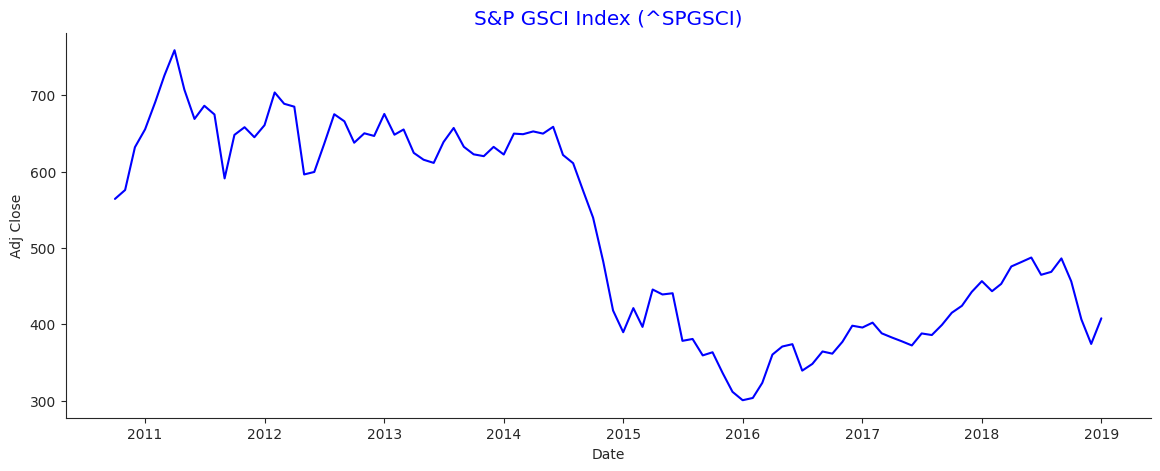

In [ ]:
plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=df, x="Date", y='Adj Close',color='blue')
sns.despine()
plt.title("S&P GSCI Index (^SPGSCI)",size='x-large',color='blue')

In [ ]:
print(f"Low:{df.loc[:,'Adj Close'].min()}")
print(f"Mean:{df.loc[:,'Adj Close'].mean()}")
print(f"High:{df.loc[:,'Adj Close'].max()}")
print(f"Standard Deviation:{df.loc[:,'Adj Close'].std()}")

Low:300.6700134277344
Mean:520.0832009887695
High:758.7899780273438
Standard Deviation:130.6299341088196


In [ ]:
data_list = []
data_test_list = []

data_close = df.loc[:,'Adj Close']
data = data_close.values
test_data = data
data = data[:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)
#data_norm = (dataset - min(dataset)) / (max(dataset)-min(dataset))

In [ ]:
train_x_one, train_y_one = split_sequences(dataset, 3)
test_x_one, test_y_one = split_sequences(data_test_set,3)

x_train_one = torch.tensor(train_x_one.reshape(train_x_one.shape[0],train_x_one.shape[1],1)).float()
y_train_one = torch.tensor(train_y_one.reshape(train_y_one.shape[0],1,1)).float()
x_test_one = torch.tensor(test_x_one.reshape(test_x_one.shape[0],test_x_one.shape[1],1)).float()
y_test_one = torch.tensor(test_y_one.reshape(test_y_one.shape[0],1,1)).float()

In [ ]:
train_x_multi ,train_y_multi = multi_time(dataset, 3, 3)
test_x_multi, test_y_multi = multi_time(data_test_set, 3, 3)

y_test_multi = test_y_multi[::1]
x_test_multi = test_x_multi[::1]
x_train_multi = train_x_multi[::1]
y_train_multi = train_y_multi[::1]

x_train_multi = torch.tensor(x_train_multi.reshape(x_train_multi.shape[0],x_train_multi.shape[1],1)).float()
y_train_multi = torch.tensor(y_train_multi.reshape(y_train_multi.shape[0],y_train_multi.shape[1],1)).float()
x_test_multi = torch.tensor(x_test_multi.reshape(x_test_multi.shape[0],x_test_multi.shape[1],1)).float()
y_test_multi = torch.tensor(y_test_multi.reshape(y_test_multi.shape[0],y_train_multi.shape[1],1)).float()

#x_train_multi = torch.tensor(train_x_multi.reshape(train_x_multi.shape[0],train_x_multi.shape[1],1)).float()
#y_train_multi = torch.tensor(train_y_multi.reshape(train_y_multi.shape[0],train_y_multi.shape[1],1)).float()
#x_test_multi = torch.tensor(test_x_multi.reshape(test_x_multi.shape[0],test_x_multi.shape[1],1)).float()
#y_test_multi = torch.tensor(test_y_multi.reshape(test_y_multi.shape[0],train_y_multi.shape[1],1)).float()

train_data_multi = myDataset(x_train_multi,y_train_multi)
test_data_multi = myDataset(x_test_multi,y_test_multi)
train_loader_multi = torch.utils.data.DataLoader(train_data_multi, batch_size=32, shuffle=False)
test_loader_multi = torch.utils.data.DataLoader(test_data_multi, batch_size=1, shuffle=False)

train_data_one = myDataset(x_train_one, y_train_one)
test_data_one = myDataset(x_test_one, y_test_one)
train_loader_one = torch.utils.data.DataLoader(train_data_one,batch_size=32,shuffle=False)
test_loader_one = torch.utils.data.DataLoader(test_data_one,batch_size=1,shuffle=False)


In [ ]:
def prediction(bnn_model, n_inputs, x_train, x_test, y_train, y_test, method = 'svi', lr = 0.01, num_epochs = 5000, plots = False):

  train_data = myDataset(x_train,y_train)
  test_data = myDataset(x_test,y_test)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False)
  test_loader= torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

  if method == 'svi':
    guide_model = AutoDiagonalNormal(bnn_model)
    fit_svi(bnn_model, guide_model, train_loader, lr = lr, model_name = "model_one", num_epochs= num_epochs, plot = plots)
    saved = torch.load("model_one.pt")
    bnn_model.load_state_dict(saved['model'])
    guide = saved['guide']
    pyro.get_param_store().load("model_one_params.pt")

    pred, plus_error, minus_error, covariance, real = predict(bnn_model, guide, test_loader)

    if plots == True:
      plot_results(n_inputs, torch.cat(real).numpy().squeeze().flatten(), np.concatenate(pred, axis=0).flatten(), np.vstack(plus_error).squeeze().tolist(),
             np.vstack(minus_error).squeeze().tolist(), title = 'BNN Model (SVI)', x_train = x_train)

    rmse_pred = rmse(torch.cat(real).numpy().squeeze().flatten(),np.concatenate(pred, axis =0))
    mape_pred = mape(torch.cat(real).numpy().squeeze().flatten(),np.concatenate(pred, axis =0))
    mae_pred = mae(torch.cat(real).numpy().squeeze().flatten(),np.concatenate(pred, axis =0))
    dist, auc = distance(pred, torch.cat(real).numpy().squeeze().flatten(), covariance)

    return pred, plus_error, minus_error, rmse_pred, mape_pred, mae_pred, dist, auc

  if method == 'mcmc':

    preds_mcmc, plus_error_mcmc, minus_error_mcmc, covariance_mcmc = predict_mcmc(bnn_model, x_train, y_train, x_test, num_samples= 50)

    if plots == True:

      plot_results(n_inputs, test_y, preds_mcmc, plus_error_mcmc, minus_error_mcmc, title = 'BNN Model (MCMC) ', x_train = x_train)

    rmse_pred = rmse(y_test.flatten().numpy(),np.concatenate(preds_mcmc, axis =0))
    mape_pred = mape(y_test.flatten().numpy(),np.concatenate(preds_mcmc, axis =0))
    mae_pred = mae(y_test.flatten().numpy(),np.concatenate(preds_mcmc, axis =0))
    dist, auc = distance(pred, y_test.flatten().numpy(), covariance_mcmc)

    return preds_mcmc, plus_error_mcmc, minus_error, rmse_pred, mape_pred, mae_pred, dist, auc




In [ ]:
model_cnn_one = BNN_onestep_cnn()
prediction(model_cnn_one, 3, x_train_one, x_test_one, y_train_one, y_test_one, method = 'svi')

  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv1d(input, weight, bias, self.stride,


NameError: name 'model' is not defined

# One_step CNN

In [ ]:
train_x_one, train_y_one = split_sequences(dataset, 3)
test_x_one, test_y_one = split_sequences(data_test_set,3)

In [ ]:
x_train_one = torch.tensor(train_x_one.reshape(train_x_one.shape[0],train_x_one.shape[1],1)).float()
y_train_one = torch.tensor(train_y_one.reshape(train_y_one.shape[0],1,1)).float()
x_test_one = torch.tensor(test_x_one.reshape(test_x_one.shape[0],test_x_one.shape[1],1)).float()
y_test_one = torch.tensor(test_y_one.reshape(test_y_one.shape[0],1,1)).float()

In [ ]:
train_data_one = myDataset(x_train_one, y_train_one)
test_data_one = myDataset(x_test_one, y_test_one)
train_loader_one = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader_one = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

NameError: name 'train_data' is not defined

In [ ]:
class BNN_onestep_cnn(PyroModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = PyroModule[nn.Conv1d](in_channels = 3, out_channels = 6, kernel_size = 2, padding = 'same') # First convolutional layer
        self.activation = PyroModule[nn.ReLU]() #ReLU
        self.layer_2 = PyroModule[nn.Conv1d](6, 12, 2, padding='same') # Second convolutional layer
        self.linear_1 = PyroModule[nn.Linear](12,1) # Fully connected layer with an output of one

        self.layer_1.weight = PyroSample(dist.Normal(0, 1).expand([6,3,2]).to_event(3)) # Convolutional layer weight prior with a standard normal distribution as prior
        self.layer_1.bias = PyroSample(dist.Normal(0, 1).expand([6]).to_event(1)) # Convolutional layer bias prior with a standard normal distribution as prior
        self.layer_2.weight = PyroSample(dist.Normal(0, 1).expand([12,6,2]).to_event(3))
        self.layer_2.bias = PyroSample(dist.Normal(0, 1).expand([12]).to_event(1))
        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([1,12]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([1]).to_event(1))

    def forward(self, x, y = None):

        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1)) # Gamma prior for the standard deviation

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y) # Update the Posterior
        return mu

  0%|          | 0/5000 [00:00<?, ?it/s]

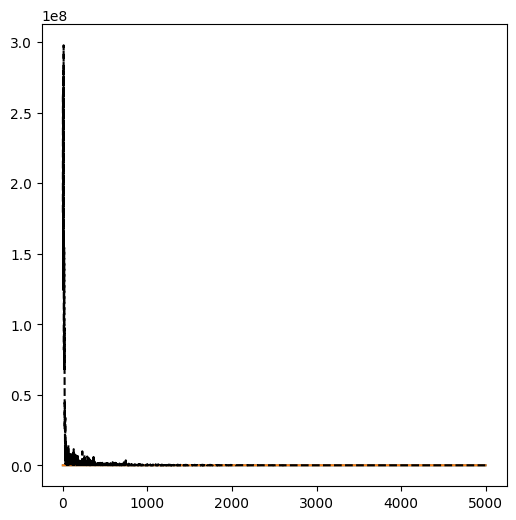

In [ ]:
model_cnn_one = BNN_onestep_cnn()
guide_model_cnn_one = AutoDiagonalNormal(model_cnn_one)

fit_svi(model_cnn_one,  guide_model_cnn_one, train_loader_one, lr=0.01, model_name = "cnn_one", num_epochs= 5000)

In [ ]:
saved_cnn_one= torch.load("cnn_one.pt")
model_cnn_one.load_state_dict(saved_cnn_one['model'])
guide_cnn_one = saved_cnn_one['guide']
pyro.get_param_store().load("cnn_one_params.pt")

In [ ]:
files.download("cnn_one.pt")
files.download("cnn_one_params.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pred_cnn_one, plus_error_cnn_one, minus_error_cnn_one, covariance_cnn_one,_ = predict(model_cnn_one, guide_cnn_one, test_loader_one)

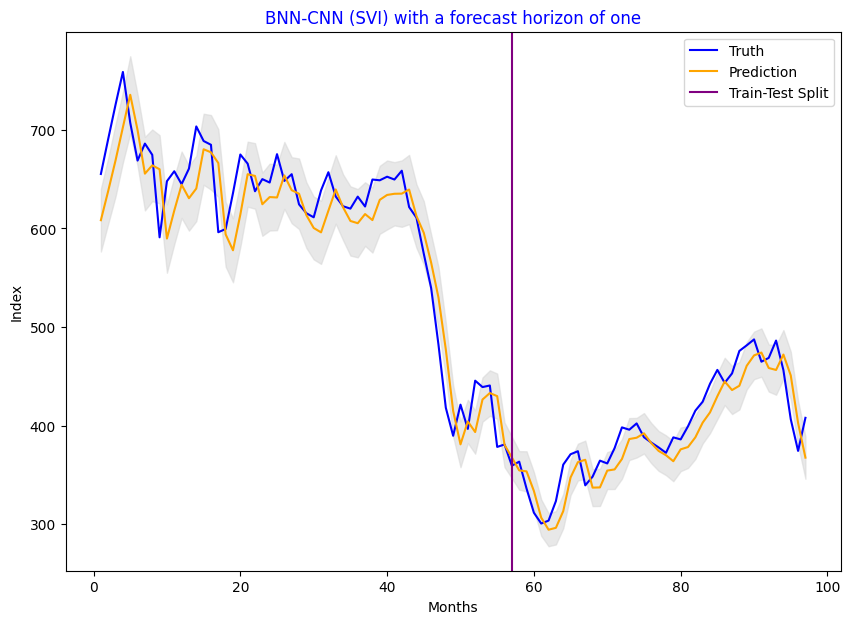

In [ ]:
plot_results(3, test_y_one, pred_cnn_one, np.vstack(plus_error_cnn_one).squeeze().tolist(),
             np.vstack(minus_error_cnn_one).squeeze().tolist(), title = 'BNN-CNN (SVI) with a forecast horizon of one', x_train = x_train_one)

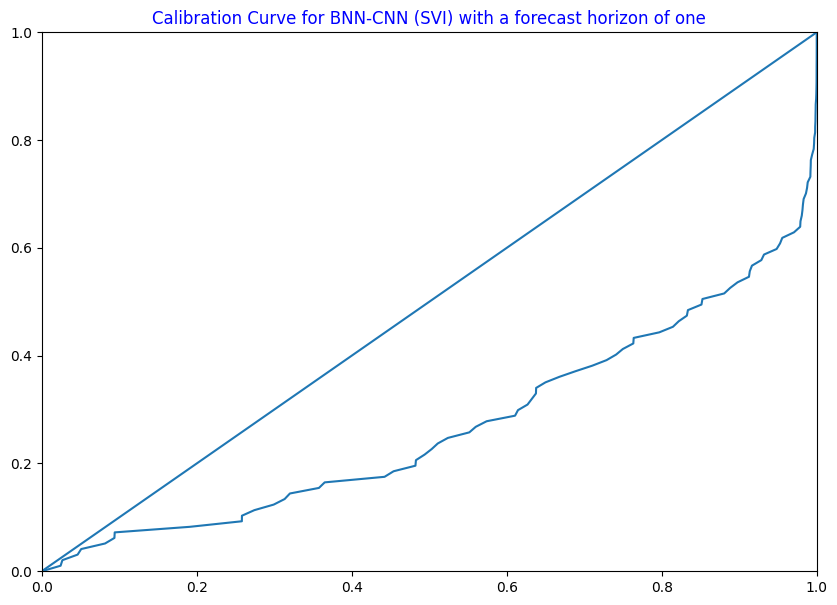

In [ ]:
auc_curve(pred_cnn_one, test_y_one, covariance_cnn_one, 'Calibration Curve for BNN-CNN (SVI) with a forecast horizon of one')

In [ ]:
curve_cnn_one = return_auc_curve(pred_cnn_one, test_y_one, covariance_cnn_one)

In [ ]:
distance(pred_cnn_one, test_y_one, covariance_cnn_one)

(0.26, 0.268)

In [ ]:
print(rmse(test_y_one.flatten(),np.concatenate(pred_cnn_one, axis =0)))
print(mape(test_y_one.flatten(),np.concatenate(pred_cnn_one, axis =0)))
print(mae(test_y_one.flatten(),np.concatenate(pred_cnn_one, axis =0)))

29.98
0.047
24.056


# Multi step CNN



In [ ]:
data_list = []
data_test_list = []
df = yf.download('^SPGSCI', start="2010-09-23", end="2019-01-10", interval='1mo')
df.reset_index(inplace=True)
data_close = df.loc[:,'Adj Close']
data = data_close.values
test_data = data
data = data [:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_x_multi ,train_y_multi = multi_time(dataset, 3, 3)
test_x_multi, test_y_multi = multi_time(data_test_set, 3, 3)

In [ ]:
y_test_multi = test_y_multi[::3]
x_test_multi = test_x_multi[::3]
x_train_multi = train_x_multi[::3]
y_train_multi = train_y_multi[::3]

In [ ]:
x_train_multi = torch.tensor(x_train_multi.reshape(x_train_multi.shape[0],x_train_multi.shape[1],1)).float()
y_train_multi = torch.tensor(y_train_multi.reshape(y_train_multi.shape[0],y_train_multi.shape[1],1)).float()
x_test_multi = torch.tensor(x_test_multi.reshape(x_test_multi.shape[0],x_test_multi.shape[1],1)).float()
y_test_multi = torch.tensor(y_test_multi.reshape(y_test_multi.shape[0],y_train_multi.shape[1],1)).float()

In [ ]:
train_data_multi = myDataset(x_train_multi,y_train_multi)
test_data_multi = myDataset(x_test_multi,y_test_multi)
train_loader_multi = torch.utils.data.DataLoader(train_data_multi, batch_size=32, shuffle=False)
test_loader_multi = torch.utils.data.DataLoader(test_data_multi, batch_size=1, shuffle=False)

In [ ]:
class BNN_multistep_cnn(PyroModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = PyroModule[nn.Conv1d](in_channels = 3, out_channels = 6, kernel_size = 2, padding = 'same') # First convolutional layer
        self.activation = PyroModule[nn.ReLU]() # ReLU
        self.layer_2 = PyroModule[nn.Conv1d](6, 12, 2, padding='same') # Second convolutional layer
        self.linear_1 = PyroModule[nn.Linear](12,3) # Fully connected layer with output of three

        self.layer_1.weight = PyroSample(dist.Normal(0, 1).expand([6,3,2]).to_event(3)) # Convolutional layer weight prior with a standard normal distribution as prior
        self.layer_1.bias = PyroSample(dist.Normal(0, 1).expand([6]).to_event(1)) # Convolutional layer bias prior with a standard normal distribution as prior
        self.layer_2.weight = PyroSample(dist.Normal(0, 1).expand([12,6,2]).to_event(3))
        self.layer_2.bias = PyroSample(dist.Normal(0, 1).expand([12]).to_event(1))
        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([3,12]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([3]).to_event(1))

    def forward(self, x, y = None):

        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1)) # Gamma prior for the standard deviation

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y) # Update the Posterior
        return mu

  0%|          | 0/5000 [00:00<?, ?it/s]

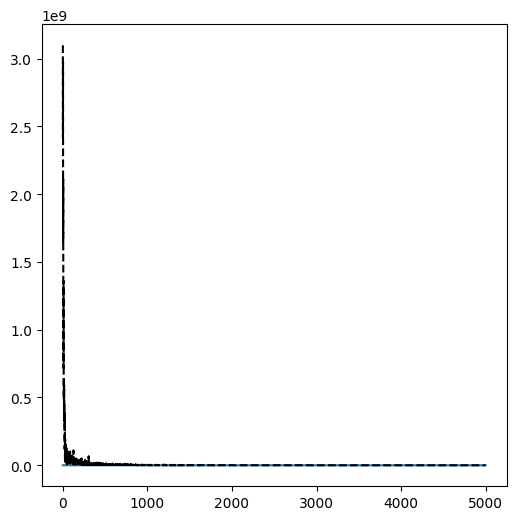

In [ ]:
model_cnn_multi = BNN_multistep_cnn()
mean_field_guide_cnn_multi = AutoDiagonalNormal(model_cnn_multi)
fit_svi(model_cnn_multi, mean_field_guide_cnn_multi, train_loader_multi, 'cnn_multi', lr=0.01, num_epochs=5000,  plot=True)

In [ ]:
saved_cnn_multi = torch.load('cnn_multi.pt')
model_cnn_multi.load_state_dict(saved_cnn_multi['model'])
guide_cnn_multi = saved_cnn_multi['guide']
pyro.get_param_store().load("cnn_multi_params.pt")

In [ ]:
pred_cnn_multi, plus_error_cnn_multi, minus_error_cnn_multi, covariance_cnn_multi, real_cnn_multi = predict(model_cnn_multi, guide_cnn_multi, test_loader_multi, num_samples = 50)

In [ ]:
pred_cnn_multi_plot, real_cnn_multi_plot, plus_error_cnn_multi_plot, minus_error_cnn_multi_plot  = multi_append(pred_cnn_multi, real_cnn_multi, plus_error_cnn_multi, minus_error_cnn_multi, covariance_cnn_multi)

In [ ]:
files.download("cnn_multi.pt")
files.download("cnn_multi_params.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

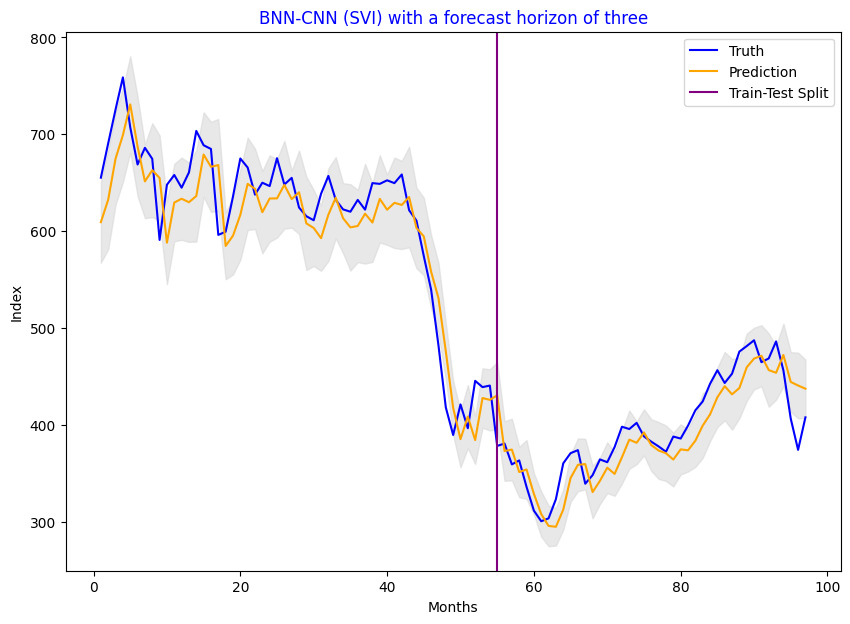

In [ ]:
plot_results(3, real_cnn_multi_plot, pred_cnn_multi_plot, plus_error_cnn_multi_plot, minus_error_cnn_multi_plot, 'BNN-CNN (SVI) with a forecast horizon of three',train_x_multi)

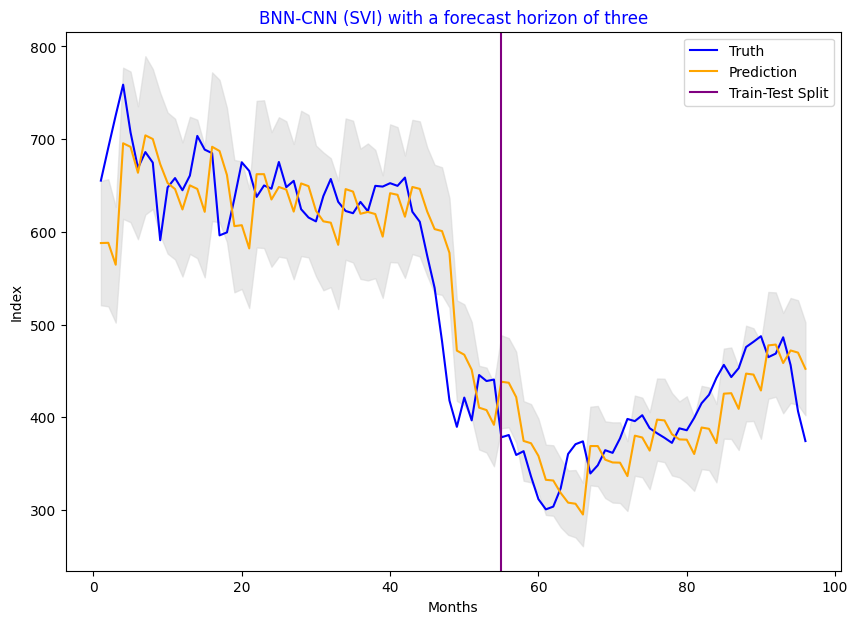

In [ ]:
plot_results(3, torch.cat(real_cnn_multi).numpy().squeeze().flatten(), np.concatenate(pred_cnn_multi, axis=0).flatten(), np.array(plus_error_cnn_multi).squeeze().flatten(),
             np.array(minus_error_cnn_multi).squeeze().flatten(), 'BNN-CNN (SVI) with a forecast horizon of three',train_x_multi)

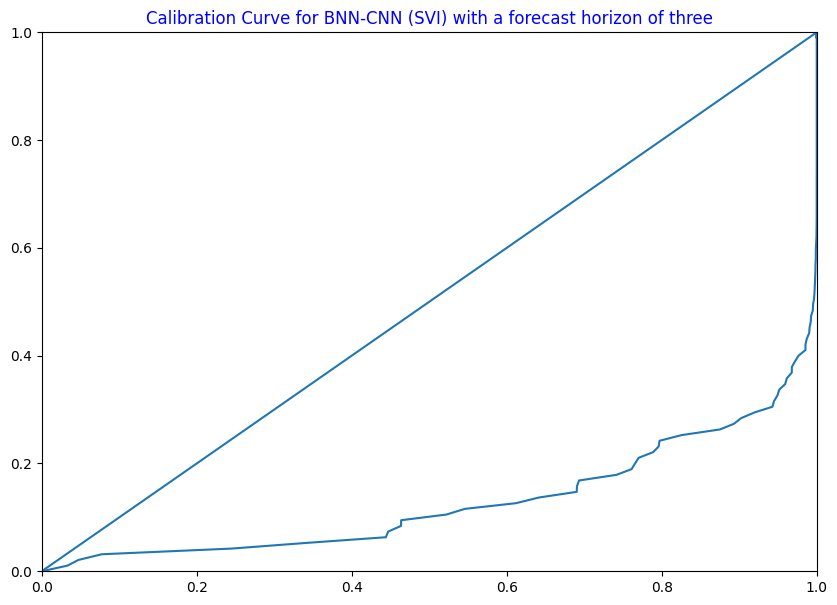

In [ ]:
auc_curve(pred_cnn_multi, test_y_multi, covariance_cnn_multi,'Calibration Curve for BNN-CNN (SVI) with a forecast horizon of three')

In [ ]:
cnn_multi_auc_curve = return_auc_curve(pred_cnn_multi, test_y_multi, covariance_cnn_multi)

In [ ]:
distance(pred_cnn_multi, test_y_multi, covariance_cnn_multi)

(0.421, 0.129)

In [ ]:
print(rmse(test_y_multi,pred_cnn_multi))
print(mape(test_y_multi,pred_cnn_multi))
print(mae(test_y_multi,pred_cnn_multi))

73.819
0.202
100.821


# One-step Linear

In [ ]:
data_list = []
data_test_list = []
df = yf.download('^SPGSCI', start="2010-09-23", end="2019-01-10", interval='1mo')
data_close = df.loc[:,'Adj Close']
data = data_close.values
test_data = data
data = data [:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_x, train_y= split_sequences(dataset, 3)
test_x, test_y = split_sequences(data_test_set,3)

In [ ]:
x_train = torch.tensor(train_x.reshape(train_x.shape[0],train_x.shape[1],1)).float()
y_train = torch.tensor(train_y.reshape(train_y.shape[0],1,1)).float()
x_test = torch.tensor(test_x.reshape(test_x.shape[0],test_x.shape[1],1)).float()
y_test = torch.tensor(test_y.reshape(test_y.shape[0],1,1)).float()

In [ ]:
train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class BNN_linear_onestep(PyroModule):
    def __init__(self):
        super().__init__()
        self.linear_1 = PyroModule[nn.Linear](3,10) # First linear layer
        self.activation = PyroModule[nn.ReLU]() # ReLU
        self.linear_2 = PyroModule[nn.Linear](10,30) # Second linear layer
        self.linear_3 = PyroModule[nn.Linear](30,1) # Third linear layer with an output of one

        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([10,3]).to_event(2)) # Linear layer weight prior with a standard normal distribution as prior
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([10]).to_event(1)) # Linear layer bias prior with a standard normal distribution as prior
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,10]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
        self.linear_3.weight = PyroSample(dist.Normal(0, 1).expand([1,30]).to_event(2))
        self.linear_3.bias = PyroSample(dist.Normal(0, 1).expand([1]).to_event(1))

    def forward(self, x, y = None):

        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        x = self.activation(self.linear_2(x))
        x = self.activation(self.linear_3(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1)) # Gamma prior for the standard deviation

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y) # Update the posterior
        return mu

  0%|          | 0/5000 [00:00<?, ?it/s]

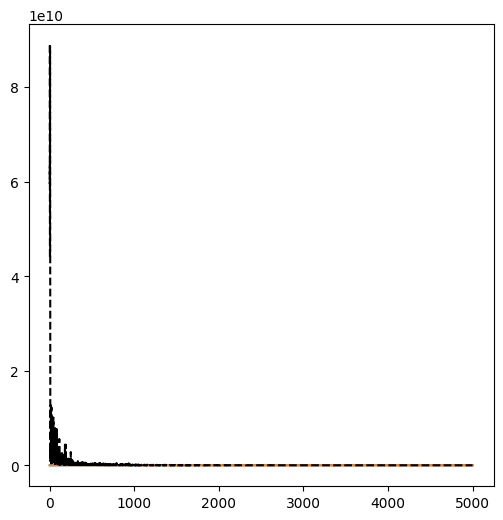

In [ ]:
model_linear_one = BNN_linear_onestep()
mean_field_guide_linear_one = AutoDiagonalNormal(model_linear_one)

fit_svi(model_linear_one, mean_field_guide_linear_one, train_loader_one, lr = 0.01, model_name = "linear_one", num_epochs= 5000)

In [ ]:
saved_linear_one = torch.load("linear_one.pt")
model_linear_one.load_state_dict(saved_linear_one['model'])
guide_linear_one = saved_linear_one['guide']
pyro.get_param_store().load("linear_one_params.pt")

In [ ]:
pred_linear_one, plus_error_linear_one, minus_error_linear_one, covariance_linear_one ,_ = predict(model_linear_one, guide_linear_one, test_loader_one)

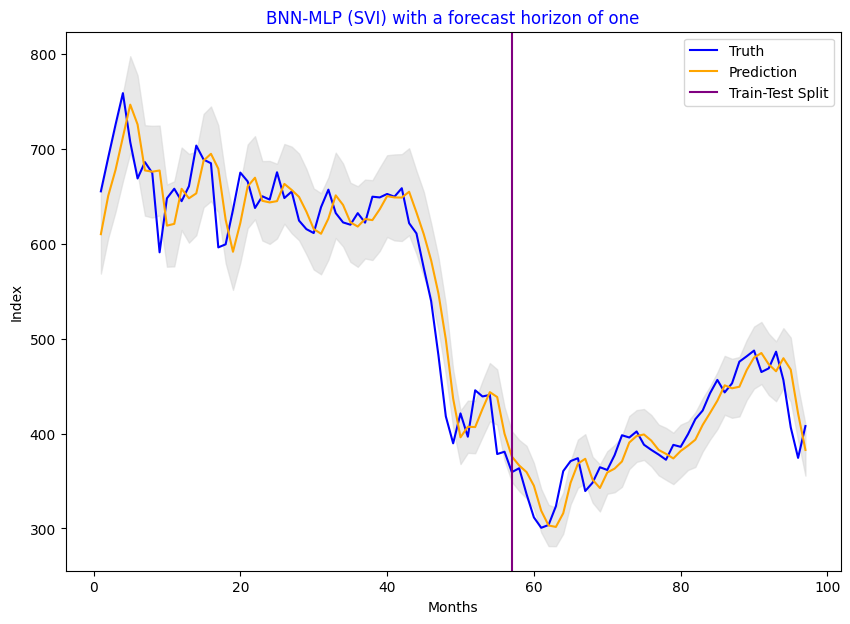

In [ ]:
plot_results(3, test_y_one, pred_linear_one, np.vstack(plus_error_linear_one).squeeze().tolist(),
             np.vstack(minus_error_linear_one).squeeze().tolist(), 'BNN-MLP (SVI) with a forecast horizon of one', x_train_one)

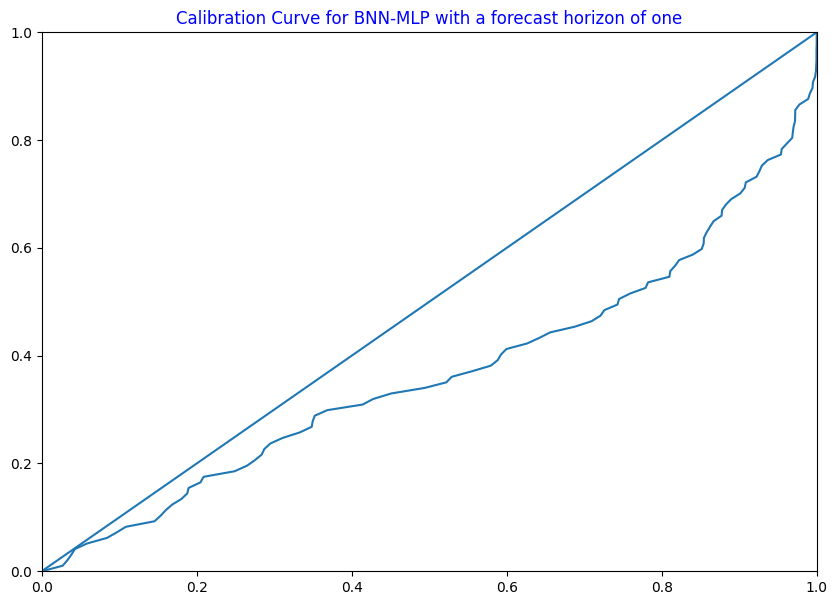

In [ ]:
auc_curve(pred_linear_one,test_y_one,covariance_linear_one, 'Calibration Curve for BNN-MLP with a forecast horizon of one')

In [ ]:
linear_one_auc_curve = return_auc_curve(pred_linear_one,test_y_one,covariance_linear_one)

In [ ]:
distance(pred_linear_one,test_y_one,covariance_linear_one)

(0.157, 0.366)

In [ ]:
print(rmse(test_y_one.flatten(),np.concatenate(pred_linear_one, axis =0)))
print(mape(test_y_one.flatten(),np.concatenate(pred_linear_one, axis =0)))
print(mae(test_y_one.flatten(),np.concatenate(pred_linear_one, axis =0)))

30.102
0.047
23.102


In [ ]:
files.download("linear_one.pt")
files.download("linear_one_params.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Multi_step_linear


In [ ]:
data_list = []
data_test_list = []
df = yf.download('^SPGSCI', start="2010-09-23", end="2019-01-10", interval='1mo')
data_close = df.loc[:,'Adj Close']
data = data_close.values
test_data = data
data = data [:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_x, train_y= multi_time(dataset, 3, 3)
test_x, test_y = multi_time(data_test_set, 3, 3)

In [ ]:
y_test = test_y[::3]
x_test = test_x[::3]
x_train = train_x[::3]
y_train = train_y[::3]

In [ ]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
y_train = torch.tensor(y_train.reshape(y_train.shape[0],y_train.shape[1],1)).float()
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
y_test = torch.tensor(y_test.reshape(y_test.shape[0],y_test.shape[1],1)).float()

In [ ]:
x_train_multi.shape

torch.Size([19, 3, 1])

In [ ]:
train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class BNN_linear_multistep(PyroModule):
    def __init__(self):
        super().__init__()
        self.linear_1 = PyroModule[nn.Linear](3,10) # First linear layer
        self.activation = PyroModule[nn.ReLU]() # ReLU
        self.linear_2 = PyroModule[nn.Linear](10,30) # Second linear layer
        self.linear_3 = PyroModule[nn.Linear](30,3) # Third linear layer with an output of three

        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([10,3]).to_event(2)) # Linear layer weight prior with a standard normal distribution as prior
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([10]).to_event(1)) # Linear layer bias prior with a standard normal distribution as prior
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,10]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
        self.linear_3.weight = PyroSample(dist.Normal(0, 1).expand([3,30]).to_event(2))
        self.linear_3.bias = PyroSample(dist.Normal(0, 1).expand([3]).to_event(1))

    def forward(self, x, y = None):

        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        x = self.activation(self.linear_2(x))
        x = self.activation(self.linear_3(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1)) # Gamma prior for the standard deviation

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y) # Update the posterior
        return mu

  0%|          | 0/5000 [00:00<?, ?it/s]

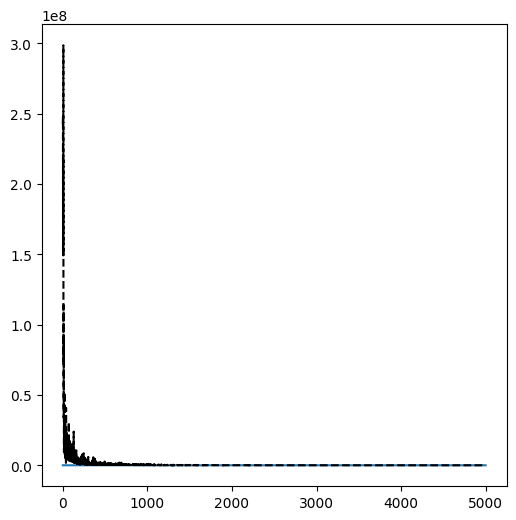

In [ ]:
model_linear_multi= BNN_linear_multistep()
mean_field_guide_linear_multi = AutoDiagonalNormal(model_linear_multi)
fit_svi(model_linear_multi, mean_field_guide_linear_multi, train_loader_multi, 'linear_multi', num_epochs = 5000)

In [ ]:
saved_model_linear_multi = torch.load("linear_multi.pt")
guide_linear_multi = saved_model_linear_multi['guide']
model_linear_multi.load_state_dict(saved_model_linear_multi['model'])
pyro.get_param_store().load("linear_multi_params.pt")

In [ ]:
pred_linear_multi, plus_error_linear_multi, minus_error_linear_multi, covariance_linear_multi, real_linear_multi  = predict(model_linear_multi, guide_linear_multi, test_loader_multi)


In [ ]:
pred_linear_multi_plot, real_linear_multi_plot, plus_error_linear_multi_plot, minus_error_linear_multi_plot  = multi_append(pred_linear_multi, real_linear_multi, plus_error_linear_multi, minus_error_linear_multi, covariance_linear_multi)

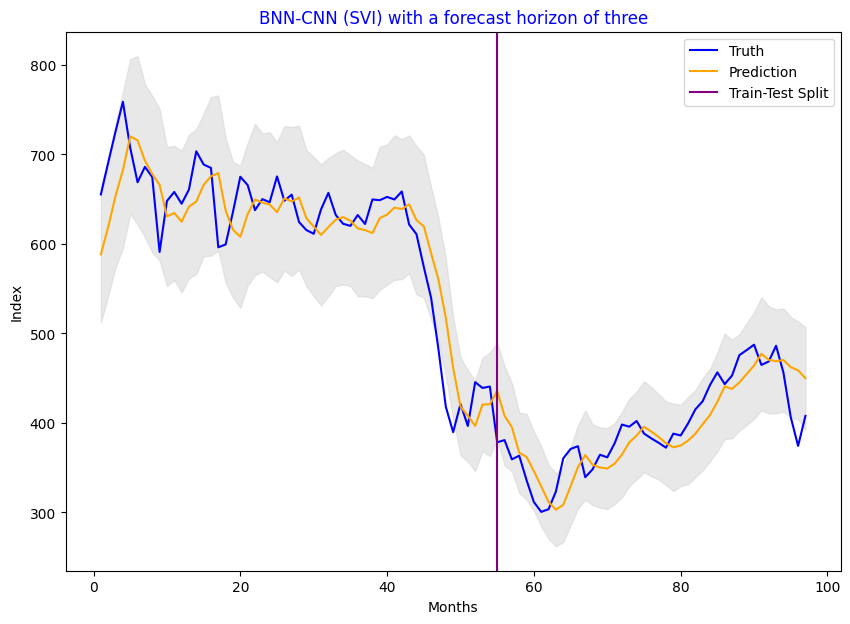

In [ ]:
plot_results(3, real_linear_multi_plot, pred_linear_multi_plot, plus_error_linear_multi_plot, minus_error_linear_multi_plot, 'BNN-CNN (SVI) with a forecast horizon of three',train_x_multi)

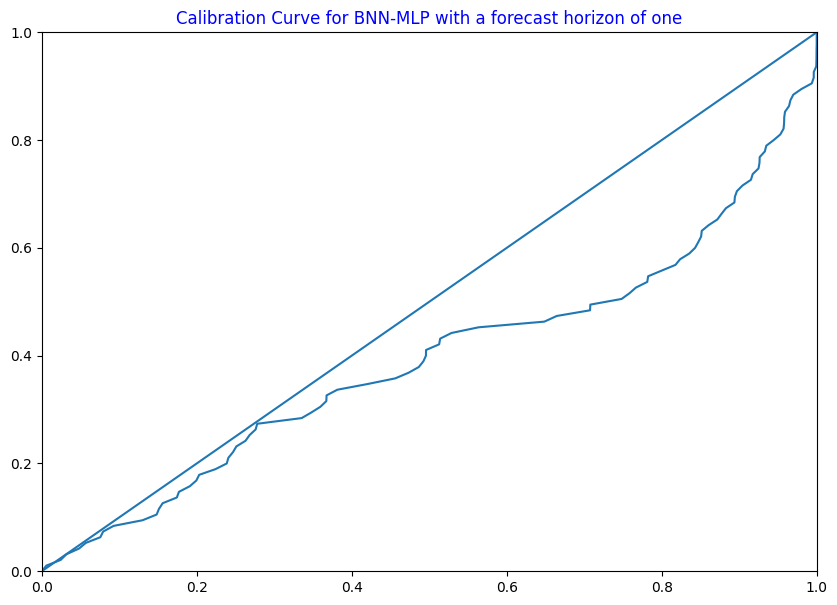

In [ ]:
auc_curve(pred_linear_multi, test_y_multi, covariance_linear_multi,'Calibration Curve for BNN-MLP with a forecast horizon of one')

In [ ]:
linear_multi_auc_curve = return_auc_curve(pred_linear_multi, test_y_multi, covariance_linear_multi)

In [ ]:
distance(pred_linear_multi, test_y_multi, covariance_linear_multi)

(0.136, 0.392)

In [ ]:
print(rmse(test_y_multi,pred_linear_multi))
print(mape(test_y_multi,pred_linear_multi))
print(mae(test_y_multi,pred_linear_multi))

79.274
0.218
106.157


#MCMC One-STEP


In [ ]:
train_x, train_y = split_sequences(dataset, 3)
test_x, test_y = split_sequences(data_test_set,3)

In [ ]:
x_train = torch.tensor(train_x.reshape(train_x.shape[0],train_x.shape[1],1)).float()
y_train = torch.tensor(train_y.reshape(train_y.shape[0],1,1)).float()
x_test = torch.tensor(test_x.reshape(test_x.shape[0],test_x.shape[1],1)).float()
y_test = torch.tensor(test_y.reshape(test_y.shape[0],1,1)).float()

In [ ]:
train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class BNN_linear_onestep(PyroModule):
    def __init__(self):
        super().__init__()
        self.linear_1 = PyroModule[nn.Linear](3,10)
        self.activation = PyroModule[nn.ReLU]()
        self.linear_2 = PyroModule[nn.Linear](10,30)
        self.linear_3 = PyroModule[nn.Linear](30,1)

        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([10,3]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([10]).to_event(1))
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,10]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
        self.linear_3.weight = PyroSample(dist.Normal(0, 1).expand([1,30]).to_event(2))
        self.linear_3.bias = PyroSample(dist.Normal(0, 1).expand([1]).to_event(1))

    def forward(self, x, y = None):

        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        x = self.activation(self.linear_2(x))
        x = self.activation(self.linear_3(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
        return mu

In [ ]:
pyro.clear_param_store()
model_mcmc_one = BNN_linear_onestep()
preds_mcmc_one, plus_error_mcmc_one, minus_error_mcmc_one, covariance_mcmc_one = predict_mcmc(model_mcmc_one, x_train_one, y_train_one, x_test_one, num_samples= 50)

Sample: 100%|██████████| 100/100 [06:54,  4.15s/it, step size=4.81e-04, acc. prob=0.979]


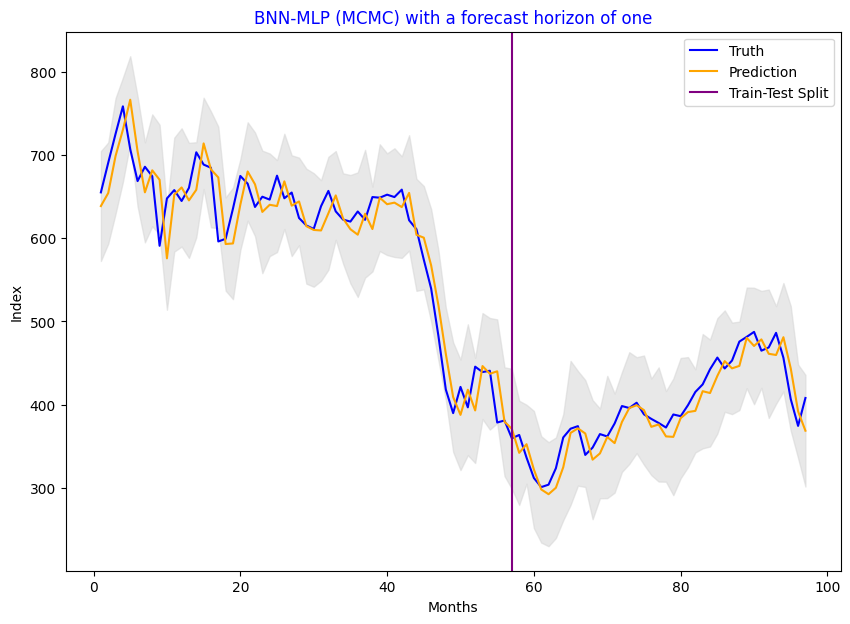

In [ ]:
plot_results(3, test_y_one, preds_mcmc_one, plus_error_mcmc_one, minus_error_mcmc_one, title = 'BNN-MLP (MCMC) with a forecast horizon of one', x_train = x_train_one)

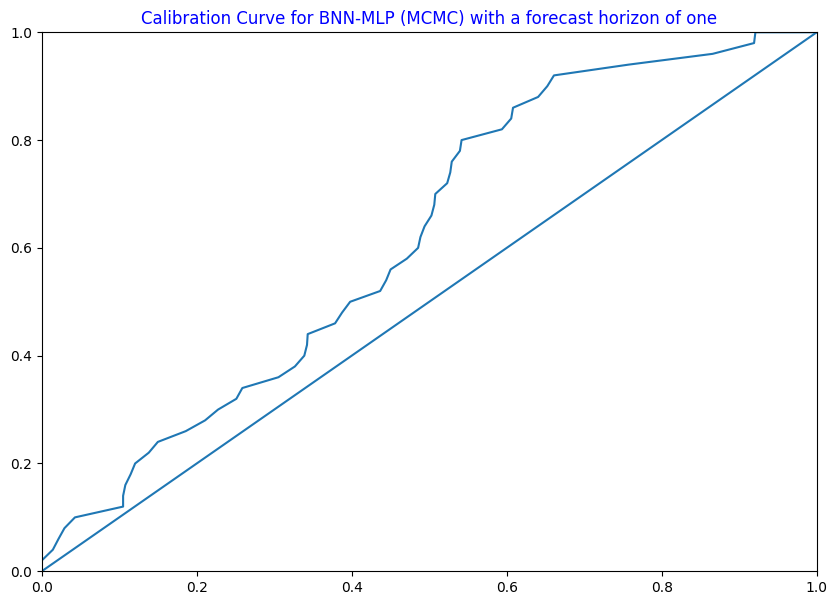

In [ ]:
auc_curve(preds_mcmc_one, y_test_one, covariance_mcmc_one, 'Calibration Curve for BNN-MLP (MCMC) with a forecast horizon of one')

In [ ]:
mcmc_one_auc_curve = return_auc_curve(preds_mcmc_one, test_y_one, covariance_mcmc_one)

<ipython-input-14-a20f59fb6237>:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  nssr = [(prediction[i] - test_y[i]) @  (np.linalg.inv(covariance_matrix[i])) @ (prediction[i] - test_y[i]).T for i in range(len(covariance_matrix))]


In [ ]:
distance(preds_mcmc_one, test_y_one, covariance_mcmc_one)

(0.14, 0.618)

In [ ]:
print(rmse(test_y_one.flatten(),np.concatenate(preds_mcmc_one.detach().numpy(), axis = 0)))
print(mape(test_y_one.flatten(),np.concatenate(preds_mcmc_one.detach().numpy(), axis = 0)))
print(mae(test_y_one.flatten(),np.concatenate(preds_mcmc_one.detach().numpy(), axis = 0)))

26.864
0.041
20.878


# MCMC 1 step BASF data


In [ ]:
from google.colab import files


uploaded = files.upload()

Saving eurusd_df_15min_2020-01-01_2024-02-06.csv to eurusd_df_15min_2020-01-01_2024-02-06.csv


In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['eurusd_df_15min_2020-01-01_2024-02-06.csv'])).dropna().head(100)
print(df)

                datetime  bid_open  bid_high  bid_low  bid_close  ask_open  \
96   2020-01-02 00:00:00   1.12184   1.12186  1.12156    1.12157   1.12198   
97   2020-01-02 00:15:00   1.12154   1.12164  1.12151    1.12155   1.12168   
98   2020-01-02 00:30:00   1.12157   1.12169  1.12152    1.12167   1.12169   
99   2020-01-02 00:45:00   1.12169   1.12183  1.12169    1.12178   1.12181   
100  2020-01-02 01:00:00   1.12177   1.12225  1.12176    1.12221   1.12190   
..                   ...       ...       ...      ...        ...       ...   
191  2020-01-02 23:45:00   1.11701   1.11704  1.11696    1.11702   1.11715   
192  2020-01-03 00:00:00   1.11703   1.11731  1.11692    1.11724   1.11717   
193  2020-01-03 00:15:00   1.11722   1.11725  1.11707    1.11720   1.11735   
194  2020-01-03 00:30:00   1.11721   1.11725  1.11718    1.11721   1.11734   
195  2020-01-03 00:45:00   1.11722   1.11756  1.11721    1.11750   1.11734   

     ask_high  ask_low  ask_close  
96    1.12199  1.12167    1

In [ ]:
data_close = df['ask_close']
data_close

96     1.12168
97     1.12169
98     1.12181
99     1.12191
100    1.12234
        ...   
191    1.11716
192    1.11736
193    1.11732
194    1.11733
195    1.11762
Name: ask_close, Length: 100, dtype: float64

In [ ]:
#without training
data_list = []
data_test_list = []

data = data_close.values
test_data = data
data = data[:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)


In [ ]:
x_train,y_train= split_sequences(dataset, 3)
x_test, y_test = split_sequences(data_test_set,3)

In [ ]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
y_train = torch.tensor(y_train.reshape(y_train.shape[0],1,1)).float()
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
y_test = torch.tensor(y_test.reshape(y_test.shape[0],1,1)).float()

train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=10,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

<ipython-input-45-3589b82bb2f5>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
<ipython-input-45-3589b82bb2f5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train.reshape(y_train.shape[0],1,1)).float()
<ipython-input-45-3589b82bb2f5>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
<ipython-input-45-3589b82bb2f5>:4: UserWarning: To copy construct

In [ ]:
pyro.clear_param_store()

model = BNN_linear_onestep()

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [03:20,  2.01s/it, step size=1.24e-04, acc. prob=0.332]


In [ ]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_test)

In [ ]:
minus_error= (preds['obs'].mean(dim=0)-2*preds['obs'].std(dim=0)).numpy().flatten()
plus_error= (preds['obs'].mean(dim=0)+2*preds['obs'].std(dim=0)).numpy().flatten()

ValueError: x and y must have same first dimension, but have shapes (97,) and (157,)

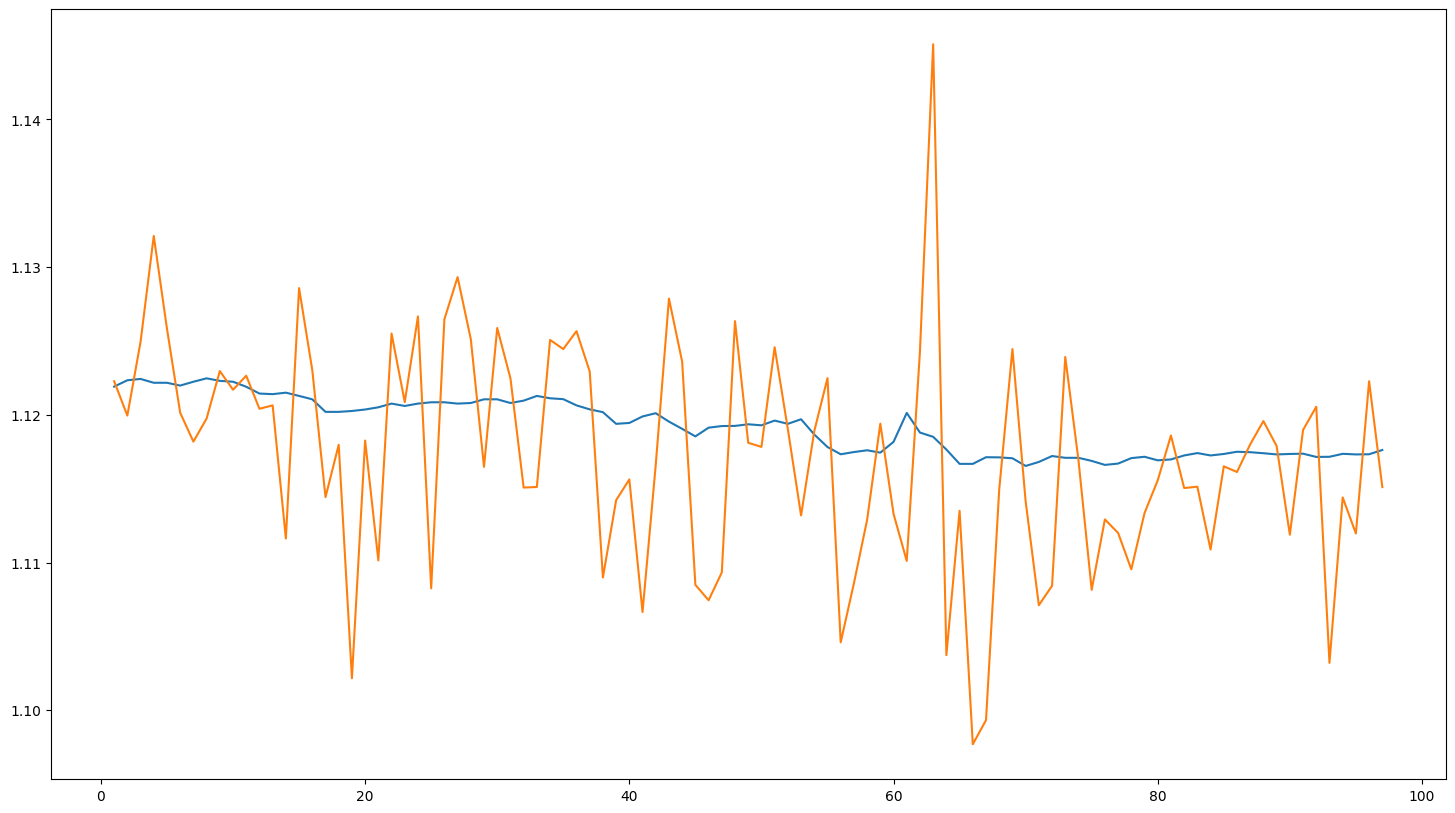

In [ ]:
plt.rcParams["figure.figsize"] = (18, 10)
x = np.arange(1, 98)

plt.plot(x, y_test.numpy().squeeze(), label='Truth')
plt.plot(x, preds['obs'].mean(dim=0), label='Prediction')

#plt.plot(x, np.vstack(plus_error_cnn).squeeze().tolist(), label='Plus Error')
#plt.plot(x, np.vstack(minus_error_cnn).squeeze().tolist(), label='Minus Error')
plt.plot(x, naive_pred, label= 'Naive model')
plt.fill_between(x, minus_error, plus_error, color='grey', alpha=0.5)
plt.axvline(x=120, linestyle='--', color='r', label='Test Set')


plt.xlabel('Months')
plt.ylabel('Index')
plt.title('MCMC with a forecast horizon of 1')
plt.legend()

plt.show()
#plt.savefig("CNN1.pdf")
#files.download("CNN1.pdf")

#MCMC Multistep

In [ ]:
data_list = []
data_test_list = []
df = yf.download('^SPGSCI', start="2010-09-23", end="2019-01-10", interval='1mo')
data_close = df.loc[:,'Adj Close']
data = data_close.values
test_data = data
data = data [:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_x_mm, train_y_mm = multi_time(dataset, 3, 3)
test_x_mm, test_y_mm = multi_time(data_test_set, 3, 3)

In [ ]:
y_test_mm = test_y_mm[::3]
x_test_mm = test_x_mm[::3]
x_train_mm = train_x_mm[::3]
y_train_mm = train_y_mm[::3]

In [ ]:
x_train_mm = torch.tensor(x_train_mm.reshape(x_train_mm.shape[0],x_train_mm.shape[1],1)).float()
y_train_mm = torch.tensor(y_train_mm.reshape(y_train_mm.shape[0],y_train_mm.shape[1],1)).float()
x_test_mm = torch.tensor(x_test_mm.reshape(x_test_mm.shape[0],x_test_mm.shape[1],1)).float()
y_test_mm = torch.tensor(y_test_mm.reshape(y_test_mm.shape[0],y_test_mm.shape[1],1)).float()

In [ ]:
train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class BNN_linear_multistep(PyroModule):
    def __init__(self):
        super().__init__()
        self.linear_1 = PyroModule[nn.Linear](3,10)
        self.activation = PyroModule[nn.ReLU]()
        self.linear_2 = PyroModule[nn.Linear](10,30)
        self.linear_3 = PyroModule[nn.Linear](30,3)

        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([10,3]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([10]).to_event(1))
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,10]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
        self.linear_3.weight = PyroSample(dist.Normal(0, 1).expand([3,30]).to_event(2))
        self.linear_3.bias = PyroSample(dist.Normal(0, 1).expand([3]).to_event(1))

    def forward(self, x, y = None):

        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        x = self.activation(self.linear_2(x))
        x = self.activation(self.linear_3(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
        return mu

In [ ]:
model_mcmc_multi = BNN_linear_multistep()
preds_mcmc_multi, plus_error_mcmc_multi, minus_error_mcmc_multi, covariance_mcmc_multi = predict_mcmc(model_mcmc_multi, x_train_multi, y_train_multi, x_test_multi, num_samples= 50)

Sample: 100%|██████████| 100/100 [09:54,  5.94s/it, step size=2.22e-03, acc. prob=0.832]


In [ ]:
pred_mcmc_multi_plot, real_mcmc_multi_plot, plus_error_mcmc_multi_plot, minus_error_mcmc_multi_plot  = multi_append(preds_mcmc_multi, real_linear_multi, plus_error_mcmc_multi, minus_error_mcmc_multi, covariance_linear_multi)

In [ ]:
len(plus_error_mcmc_multi)

95

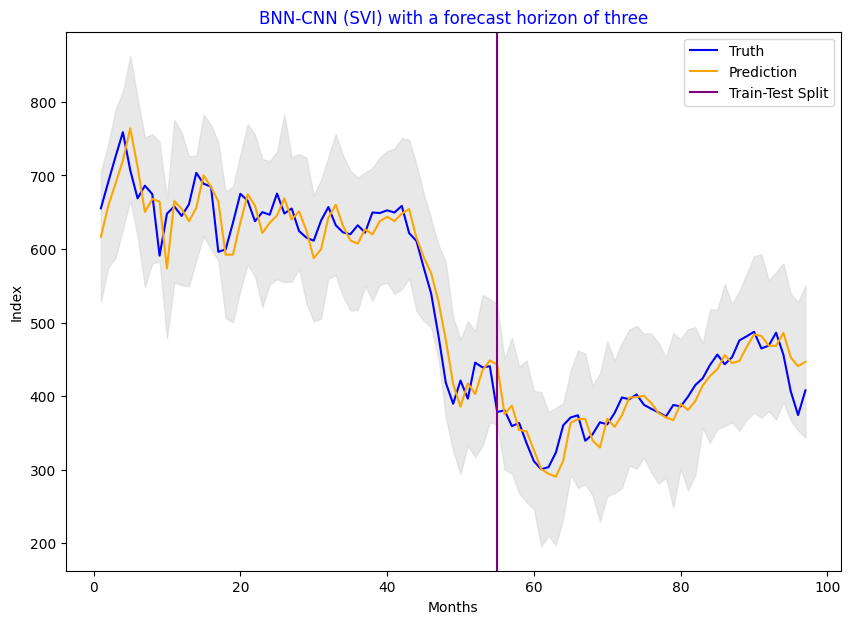

In [ ]:
plot_results(3, real_mcmc_multi_plot, pred_mcmc_multi_plot, plus_error_mcmc_multi_plot, minus_error_mcmc_multi_plot, 'BNN-CNN (SVI) with a forecast horizon of three',train_x_multi)

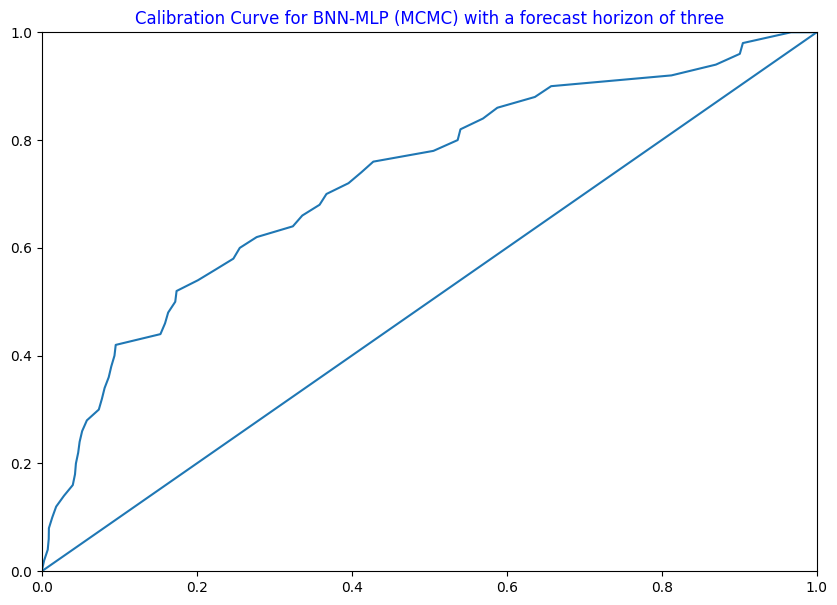

In [ ]:
auc_curve(preds_mcmc_multi, test_y_multi, covariance_mcmc_multi, 'Calibration Curve for BNN-MLP (MCMC) with a forecast horizon of three')

In [ ]:
mcmc_multi_auc_curve = return_auc_curve(preds_mcmc_multi, test_y_multi, covariance_mcmc_multi)

In [ ]:
distance(preds_mcmc_multi, test_y_multi, covariance_mcmc_multi)

(0.251, 0.726)

In [ ]:
print(rmse(y_test_multi.squeeze().numpy(), preds_mcmc_multi.numpy()))
print(mape(y_test_multi.squeeze().numpy(), preds_mcmc_multi.numpy()))
print(mae(y_test_multi.squeeze().numpy(), preds_mcmc_multi.numpy()))

70.762
0.194
95.642


Text(0.5, 0, 'Time (Months)')

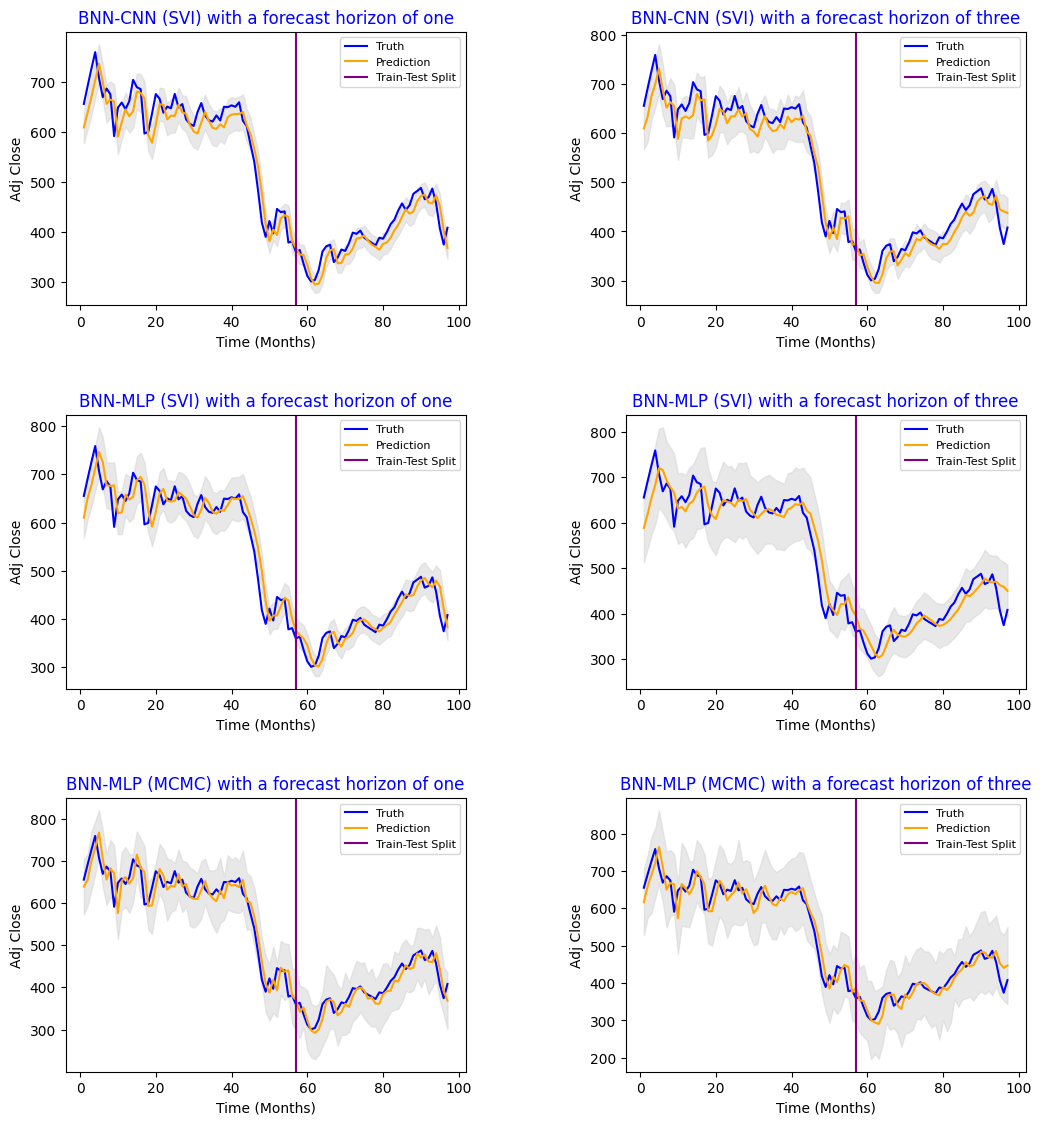

In [ ]:
fig, axs = plt.subplots(3, 2)

plt.rcParams["figure.figsize"] = (12, 13)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.4,hspace=0.4)

x = np.arange(1, 98)
axs[0, 0].plot(x, test_y_one, label='Truth', color = 'blue')
axs[0, 0].plot(x, pred_cnn_one, label='Prediction',color = 'orange')
axs[0, 0].fill_between(x, np.vstack(plus_error_cnn_one).squeeze().tolist(),
             np.vstack(minus_error_cnn_one).squeeze().tolist(), color='lightgray', alpha=0.5)
axs[0, 0].axvline(x=len(x_train_one), linestyle='-', color='purple', label='Train-Test Split')
axs[0, 0].set_title('BNN-CNN (SVI) with a forecast horizon of one', color = 'blue')
axs[0,0].legend(fontsize=8,loc ="upper right")
axs[0,0].set_ylabel('Adj Close')
axs[0,0].set_xlabel('Time (Months)')

x = np.arange(1, 98)
axs[0, 1].plot(x, real_cnn_multi_plot, label='Truth', color = 'blue')
axs[0, 1].plot(x, pred_cnn_multi_plot, label='Prediction',color = 'orange')
axs[0, 1].fill_between(x, plus_error_cnn_multi_plot,minus_error_cnn_multi_plot, color='lightgray', alpha=0.5)
axs[0, 1].axvline(x=len(x_train_one), linestyle='-', color='purple', label='Train-Test Split')
axs[0, 1].set_title('BNN-CNN (SVI) with a forecast horizon of three', color = 'blue')
axs[0,1].legend(fontsize=8,loc ="upper right")
axs[0,1].set_ylabel('Adj Close')
axs[0,1].set_xlabel('Time (Months)')


x = np.arange(1, len(test_y_one)+1)
axs[1, 0].plot(x, test_y_one, label='Truth', color = 'blue')
axs[1, 0].plot(x, pred_linear_one, label='Prediction',color = 'orange')
axs[1, 0].fill_between(x, np.vstack(plus_error_linear_one).squeeze().tolist(),
             np.vstack(minus_error_linear_one).squeeze().tolist(), color='lightgray', alpha=0.5)
axs[1, 0].axvline(x=len(x_train_one), linestyle='-', color='purple', label='Train-Test Split')
axs[1, 0].set_title('BNN-MLP (SVI) with a forecast horizon of one', color = 'blue')
axs[1,0].legend(fontsize=8,loc ="upper right")
axs[1,0].set_ylabel('Adj Close')
axs[1,0].set_xlabel('Time (Months)')


x = np.arange(1, 97+1)
axs[1, 1].plot(x, real_linear_multi_plot, label='Truth', color = 'blue')
axs[1, 1].plot(x, pred_linear_multi_plot, label='Prediction',color = 'orange')
axs[1, 1].fill_between(x, plus_error_linear_multi_plot, minus_error_linear_multi_plot, color='lightgray', alpha=0.5)
axs[1, 1].axvline(x=len(x_train_one), linestyle='-', color='purple', label='Train-Test Split')
axs[1, 1].set_title('BNN-MLP (SVI) with a forecast horizon of three', color = 'blue')
axs[1,1].legend(fontsize=8,loc ="upper right")
axs[1,1].set_ylabel('Adj Close')
axs[1,1].set_xlabel('Time (Months)')


x = np.arange(1, len(test_y_one)+1)
axs[2, 0].plot(x, test_y_one, label='Truth', color = 'blue')
axs[2, 0].plot(x, preds_mcmc_one, label='Prediction',color = 'orange')
axs[2, 0].fill_between(x, plus_error_mcmc_one, minus_error_mcmc_one, color='lightgray', alpha=0.5)
axs[2, 0].axvline(x=len(x_train_one), linestyle='-', color='purple', label='Train-Test Split')
axs[2, 0].set_title('BNN-MLP (MCMC) with a forecast horizon of one', color = 'blue')
axs[2,0].legend(fontsize=8,loc ="upper right")
axs[2,0].set_ylabel('Adj Close')
axs[2,0].set_xlabel('Time (Months)')


x = np.arange(1, 98)
axs[2, 1].plot(x, real_linear_multi_plot, label='Truth', color = 'blue')
axs[2, 1].plot(x, pred_mcmc_multi_plot, label='Prediction',color = 'orange')
axs[2, 1].fill_between(x, plus_error_mcmc_multi_plot, minus_error_mcmc_multi_plot, color='lightgray', alpha=0.5)
axs[2, 1].axvline(x=len(x_train_one), linestyle='-', color='purple', label='Train-Test Split')
axs[2, 1].set_title('BNN-MLP (MCMC) with a forecast horizon of three', color = 'blue')
axs[2,1].legend(fontsize=8,loc ="upper right")
axs[2,1].set_ylabel('Adj Close')
axs[2,1].set_xlabel('Time (Months)')




In [ ]:
  plt.plot(curve[:,0], curve[:,1])
  plt.axline([0, 0], [1, 1])
  plt.title(title, color = 'blue')

Text(0.5, 0, 'Predicted Probability')

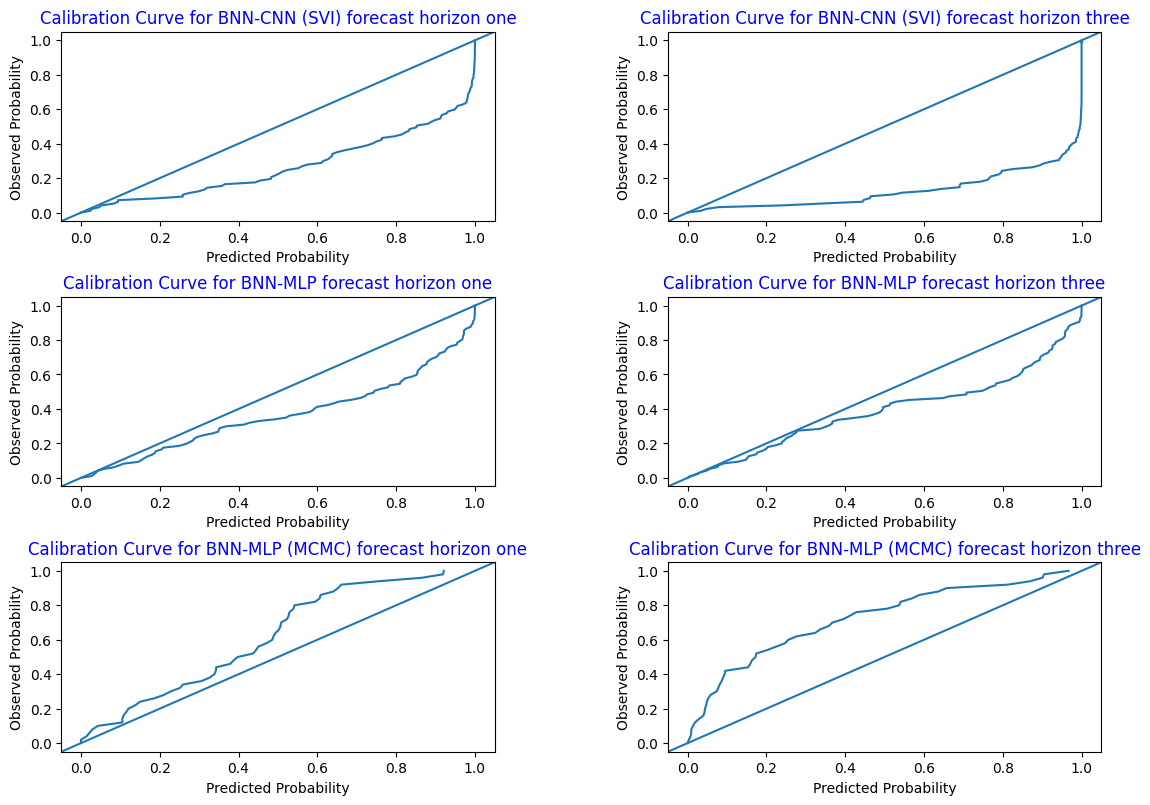

In [ ]:
fig, axs = plt.subplots(3, 2)

plt.rcParams["figure.figsize"] = (13, 9)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.4,hspace=0.4)

axs[0, 0].plot(curve_cnn_one[:,0], curve_cnn_one[:,1])
axs[0, 0].axline([0, 0], [1, 1])
axs[0, 0].set_title('Calibration Curve for BNN-CNN (SVI) forecast horizon one', color = 'blue')
axs[0,0].set_ylabel('Observed Probability')
axs[0,0].set_xlabel('Predicted Probability')



axs[0, 1].plot(cnn_multi_auc_curve[:,0], cnn_multi_auc_curve[:,1])
axs[0, 1].axline([0, 0], [1, 1])
axs[0, 1].set_title('Calibration Curve for BNN-CNN (SVI) forecast horizon three', color = 'blue')
axs[0,1].set_ylabel('Observed Probability')
axs[0,1].set_xlabel('Predicted Probability')


axs[1, 0].plot(linear_one_auc_curve[:,0], linear_one_auc_curve[:,1])
axs[1, 0].axline([0, 0], [1, 1])
axs[1, 0].set_title('Calibration Curve for BNN-MLP forecast horizon one', color = 'blue')
axs[1,0].set_ylabel('Observed Probability')
axs[1,0].set_xlabel('Predicted Probability')


axs[1, 1].plot(linear_multi_auc_curve[:,0], linear_multi_auc_curve[:,1])
axs[1, 1].axline([0, 0], [1, 1])
axs[1, 1].set_title('Calibration Curve for BNN-MLP forecast horizon three', color = 'blue')
axs[1,1].set_ylabel('Observed Probability')
axs[1,1].set_xlabel('Predicted Probability')


axs[2, 0].plot(mcmc_one_auc_curve[:,0], mcmc_one_auc_curve[:,1])
axs[2, 0].axline([0, 0], [1, 1])
axs[2, 0].set_title('Calibration Curve for BNN-MLP (MCMC) forecast horizon one', color = 'blue')
axs[2,0].set_ylabel('Observed Probability')
axs[2,0].set_xlabel('Predicted Probability')


axs[2, 1].plot(mcmc_multi_auc_curve[:,0], mcmc_multi_auc_curve[:,1])
axs[2, 1].axline([0, 0], [1, 1])
axs[2, 1].set_title('Calibration Curve for BNN-MLP (MCMC) forecast horizon three', color = 'blue')
axs[2,1].set_ylabel('Observed Probability')
axs[2,1].set_xlabel('Predicted Probability')

#New Values


In [ ]:
data_list_new = []
data_test_list_new = []
df_new = yf.download('^SPGSCI', start="2020-01-10", end="2024-01-10", interval='1mo')
data_close_new = df_new.loc[:,'Adj Close']
data_new = data_close_new.values
test_data_new = data_new
data_new = data_new[:-40]
data_list_new.append(data_new)
data_test_list_new.append(test_data_new)
data_test_set_new = np.concatenate(data_test_list_new, axis=0)
dataset_new = np.concatenate(data_list_new, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
len(data_test_set_new )

48

In [ ]:
test_x_one_new, test_y_one_new = split_sequences(data_test_set_new,3)

Text(0.5, 1.0, 'S&P GSCI Index (^SPGSCI)')

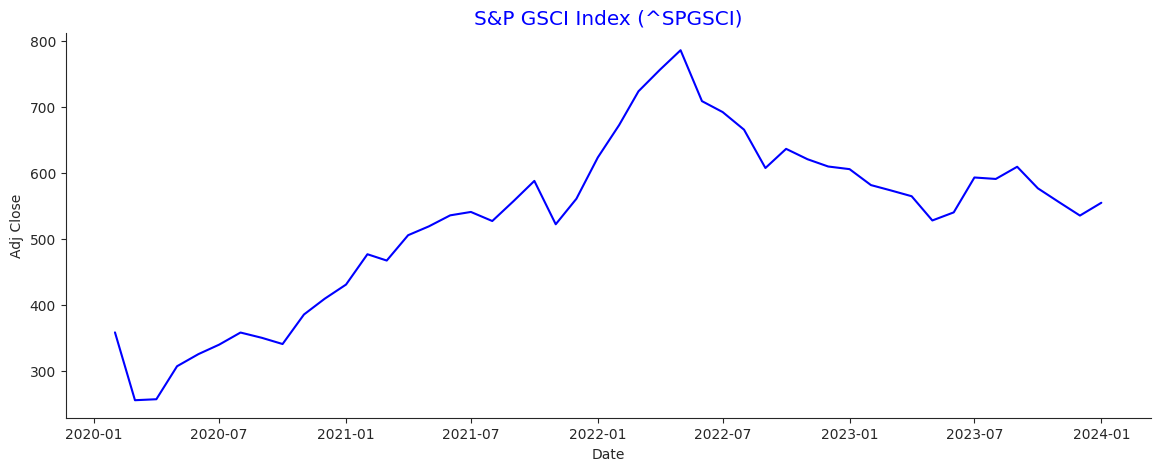

In [ ]:
df_new.reset_index(inplace=True)
plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=df_new, x="Date", y='Adj Close',color='blue')
sns.despine()
plt.title("S&P GSCI Index (^SPGSCI)",size='x-large',color='blue')

In [ ]:
x_test_one_new = torch.tensor(test_x_one_new.reshape(test_x_one_new.shape[0],test_x_one_new.shape[1],1)).float()
y_test_one_new = torch.tensor(test_y_one_new.reshape(test_y_one_new.shape[0],1,1)).float()

In [ ]:
test_x_multi_new, test_y_multi_new = multi_time(data_test_set_new, 3, 3)

In [ ]:
test_data_new = myDataset(x_test_one_new, y_test_one_new)
test_loader_new = torch.utils.data.DataLoader(test_data_new,batch_size=1,shuffle=False)

In [ ]:
saved_cnn_one= torch.load("cnn_one.pt")
model_cnn_one.load_state_dict(saved_cnn_one['model'])
guide_cnn_one = saved_cnn_one['guide']
pyro.get_param_store().load("cnn_one_params.pt")

In [ ]:
pred_cnn_one_new, plus_error_cnn_one_new, minus_error_cnn_one_new, covariance_cnn_one_new,_ = predict(model_cnn_one, guide_cnn_one, test_loader_new)

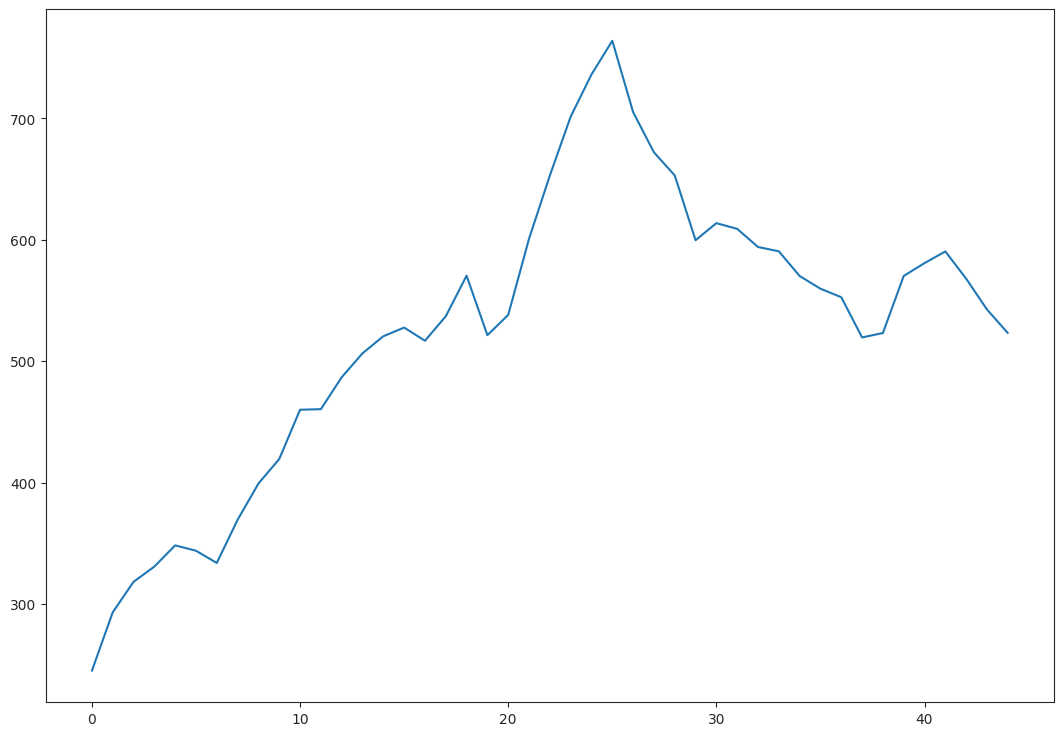

In [ ]:
plt.plot(pred_cnn_one_new)

In [ ]:
test_x_multi_new, test_y_multi_new = multi_time(data_test_set_new, 3, 3)
train_x_multi_new ,train_y_multi_new = multi_time(dataset_new, 3, 3)

y_test_multi_new = test_y_multi_new[::1]
x_test_multi_new = test_x_multi_new[::1]
y_train_multi_new = train_y_multi_new[::1]
x_train_multi_new = train_x_multi_new[::1]
y_train_multi_new = train_y_multi_new[::1]

x_train_multi_new = torch.tensor(x_train_multi_new .reshape(x_train_multi_new .shape[0],x_train_multi_new .shape[1],1)).float()
y_train_multi_new  = torch.tensor(y_train_multi_new .reshape(y_train_multi_new .shape[0],y_train_multi_new .shape[1],1)).float()
x_test_multi_new = torch.tensor(x_test_multi_new.reshape(x_test_multi_new.shape[0],x_test_multi_new.shape[1],1)).float()
y_test_multi_new= torch.tensor(y_test_multi_new.reshape(y_test_multi_new.shape[0],y_train_multi_new.shape[1],1)).float()

test_data_multi_new = myDataset(x_test_multi_new,y_test_multi_new)
test_loader_multi_new = torch.utils.data.DataLoader(test_data_multi_new, batch_size=1, shuffle=False)

In [ ]:
saved_cnn_multi = torch.load('cnn_multi.pt')
model_cnn_multi.load_state_dict(saved_cnn_multi['model'])
guide_cnn_multi = saved_cnn_multi['guide']
pyro.get_param_store().load("cnn_multi_params.pt")

In [ ]:
pred_cnn_multi_new, plus_error_cnn_multi_new, minus_error_cnn_multi_new, covariance_cnn_multi_new, real_cnn_multi_new = predict(model_cnn_multi, guide_cnn_multi, test_loader_multi_new, num_samples = 500)

In [ ]:
pred_cnn_multi_plot_new, real_cnn_multi_plot_new, plus_error_cnn_multi_plot_new, minus_error_cnn_multi_plot_new  = multi_append(pred_cnn_multi_new, real_cnn_multi_new, plus_error_cnn_multi_new, minus_error_cnn_multi_new, covariance_linear_multi)

In [ ]:
saved_linear_one = torch.load("linear_one.pt")
model_linear_one.load_state_dict(saved_linear_one['model'])
guide_linear_one = saved_linear_one['guide']
pyro.get_param_store().load("linear_one_params.pt")

pred_linear_one_new, plus_error_linear_one_new, minus_error_linear_one_new, covariance_linear_one_new ,_ = predict(model_linear_one, guide_linear_one, test_loader_new)

Sample:  58%|█████▊    | 58/100 [23:12, 24.00s/it, step size=7.19e-04, acc. prob=1.000]


In [ ]:
saved_model_linear_multi = torch.load("linear_multi.pt")
guide_linear_multi = saved_model_linear_multi['guide']
model_linear_multi.load_state_dict(saved_model_linear_multi['model'])
pyro.get_param_store().load("linear_multi_params.pt")

pred_linear_multi_new, plus_error_linear_multi_new, minus_error_linear_multi_new, covariance_linear_multi_new, real_new = predict(model_linear_multi, guide_linear_multi, test_loader_multi_new)

pred_linear_multi_plot_new, real_linear_multi_plot_new, plus_error_linear_multi_plot_new, minus_error_linear_multi_plot_new  = multi_append(pred_linear_multi_new, real_new, plus_error_linear_multi_new, minus_error_linear_multi_new, covariance_linear_multi)


In [ ]:
preds_mcmc_one_new, plus_error_mcmc_one_new, minus_error_mcmc_one_new, covariance_mcmc_one_new = predict_mcmc(model_mcmc_one, x_train_one, y_train_one, x_test_one_new, num_samples= 50)

Sample: 100%|██████████| 100/100 [07:29,  4.49s/it, step size=1.00e-03, acc. prob=0.936]


In [ ]:
preds_mcmc_multi_new, plus_error_mcmc_multi_new, minus_error_mcmc_multi_new, covariance_mcmc_multi_new = predict_mcmc(model_mcmc_multi, x_train_multi, y_train_multi, x_test_multi_new, num_samples= 50)


Sample: 100%|██████████| 100/100 [08:16,  4.96s/it, step size=2.06e-04, acc. prob=0.981]


In [ ]:
pred_mcmc_multi_plot_new, real_mcmc_multi_plot_new, plus_error_mcmc_multi_plot_new, minus_error_mcmc_multi_plot_new  = multi_append(preds_mcmc_multi_new, real_cnn_multi_new, plus_error_mcmc_multi_new, minus_error_mcmc_multi_new, covariance_linear_multi)

In [ ]:
minus_error_mcmc_one_new.flatten()

array([188.41393, 250.8377 , 264.591  , 269.07214, 281.24615, 283.5879 ,
       278.2893 , 320.21292, 347.50552, 372.5426 , 412.01956, 410.65668,
       455.48712, 449.4855 , 463.10968, 467.50208, 457.42288, 497.6906 ,
       519.48413, 446.58942, 482.43445, 556.0523 , 607.56866, 645.04706,
       686.35657, 718.57184, 630.9172 , 613.1521 , 590.94543, 536.256  ,
       553.1589 , 556.04944, 533.4206 , 528.04834, 520.5835 , 492.4652 ,
       495.83167, 459.45374, 468.1743 , 523.6433 , 533.2684 , 539.8092 ,
       501.42648, 494.6256 , 454.9533 ], dtype=float32)

Text(0.5, 0, 'Time (Months)')

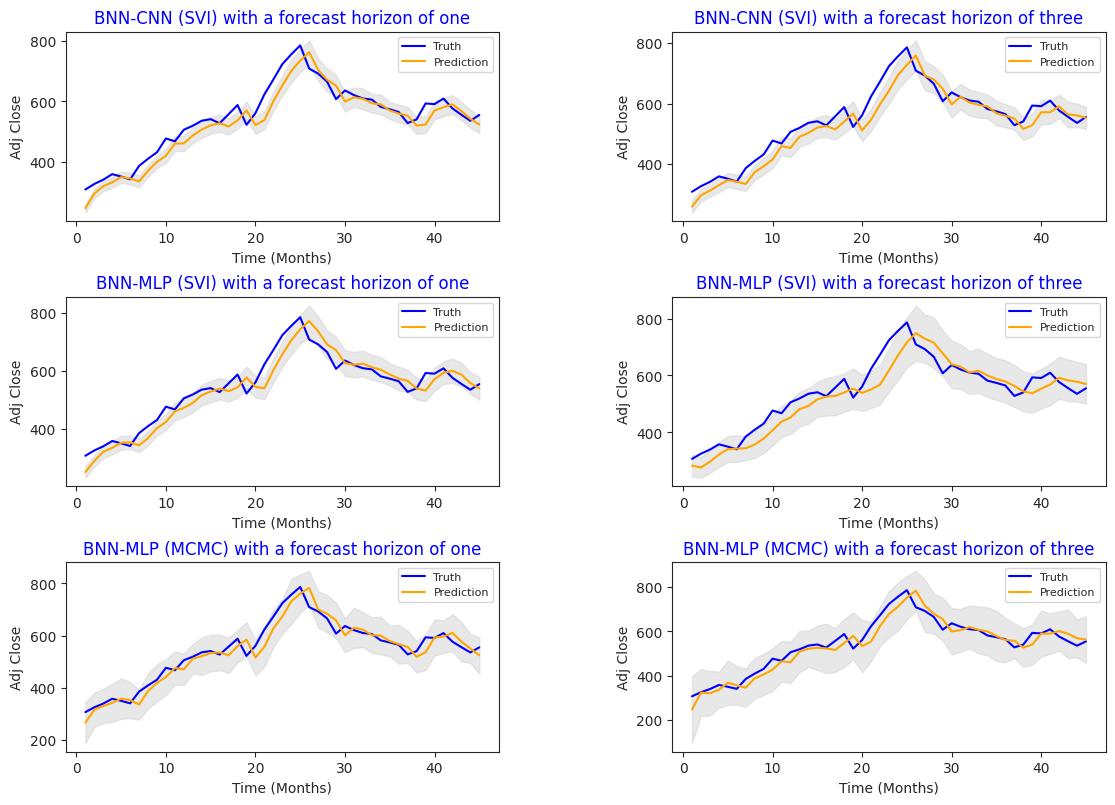

In [ ]:
fig, axs = plt.subplots(3, 2)

plt.rcParams["figure.figsize"] = (13, 9)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.4,hspace=0.4)
plt.yticks = [200,400,600,800]

x = np.arange(1, len(test_y_one_new)+1)
axs[0, 0].plot(x, test_y_one_new , label='Truth', color = 'blue')
axs[0, 0].plot(x, pred_cnn_one_new, label='Prediction',color = 'orange')
axs[0, 0].fill_between(x, np.vstack(plus_error_cnn_one_new).squeeze().tolist(),
             np.vstack(minus_error_cnn_one_new).squeeze().tolist(), color='lightgray', alpha=0.5)
axs[0, 0].set_title('BNN-CNN (SVI) with a forecast horizon of one', color = 'blue')
axs[0,0].legend(fontsize=8,loc ="upper right")
axs[0,0].set_ylabel('Adj Close')
axs[0,0].set_xlabel('Time (Months)')


x = np.arange(1, len(real_cnn_multi_plot_new)+1)
axs[0, 1].plot(x, real_cnn_multi_plot_new, label='Truth', color = 'blue')
axs[0, 1].plot(x, pred_cnn_multi_plot_new, label='Prediction',color = 'orange')
axs[0, 1].fill_between(x, plus_error_cnn_multi_plot_new, minus_error_cnn_multi_plot_new, color='lightgray', alpha=0.5)
axs[0, 1].set_title('BNN-CNN (SVI) with a forecast horizon of three', color = 'blue')
axs[0,1].legend(fontsize=8,loc ="upper right")
axs[0,1].set_ylabel('Adj Close')
axs[0,1].set_xlabel('Time (Months)')

x = np.arange(1, len(test_y_one_new)+1)
axs[1, 0].plot(x, test_y_one_new, label='Truth', color = 'blue')
axs[1, 0].plot(x, pred_linear_one_new, label='Prediction',color = 'orange')
axs[1, 0].fill_between(x, np.vstack(plus_error_linear_one_new).squeeze().tolist(),
             np.vstack(minus_error_linear_one_new).squeeze().tolist(), color='lightgray', alpha=0.5)
axs[1, 0].set_title('BNN-MLP (SVI) with a forecast horizon of one', color = 'blue')
axs[1,0].legend(fontsize=8,loc ="upper right")
axs[1,0].set_ylabel('Adj Close')
axs[1,0].set_xlabel('Time (Months)')

x = np.arange(1, len(real_cnn_multi_plot_new)+1)
axs[1, 1].plot(x, real_cnn_multi_plot_new, label='Truth', color = 'blue')
axs[1, 1].plot(x, pred_linear_multi_plot_new, label='Prediction',color = 'orange')
axs[1, 1].fill_between(x, plus_error_linear_multi_plot_new, minus_error_linear_multi_plot_new, color='lightgray', alpha=0.5)
axs[1, 1].set_title('BNN-MLP (SVI) with a forecast horizon of three', color = 'blue')
axs[1,1].legend(fontsize=8,loc ="upper right")
axs[1,1].set_ylabel('Adj Close')
axs[1,1].set_xlabel('Time (Months)')


x = np.arange(1, len(test_y_one_new)+1)
axs[2, 0].plot(x, test_y_one_new, label='Truth', color = 'blue')
axs[2, 0].plot(x, preds_mcmc_one_new, label='Prediction',color = 'orange')
axs[2, 0].fill_between(x, plus_error_mcmc_one_new.flatten(), minus_error_mcmc_one_new.flatten(), color='lightgray', alpha=0.5)
axs[2, 0].set_title('BNN-MLP (MCMC) with a forecast horizon of one', color = 'blue')
axs[2, 0].legend(fontsize=8,loc ="upper right")
axs[2,0].set_ylabel('Adj Close')
axs[2,0].set_xlabel('Time (Months)')


x = np.arange(1, len(real_cnn_multi_plot_new)+1)
axs[2, 1].plot(x, real_cnn_multi_plot_new, label='Truth', color = 'blue')
axs[2, 1].plot(x, pred_mcmc_multi_plot_new, label='Prediction',color = 'orange')
axs[2, 1].fill_between(x, plus_error_mcmc_multi_plot_new, minus_error_mcmc_multi_plot_new, color='lightgray', alpha=0.5)
axs[2, 1].set_title('BNN-MLP (MCMC) with a forecast horizon of three', color = 'blue')
axs[2,1].legend(fontsize=8,loc ="upper right")
axs[2,1].set_ylabel('Adj Close')
axs[2,1].set_xlabel('Time (Months)')

